In [1]:
###################################################
######### Code to generate ESM projections ########
###################################################

# this is run on JASMIN, accessing the files directly from the CEDA catalogue

#first import required packages
import pandas as pd
import xarray as xr
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import scipy
import scipy.interpolate
import pickle 
# for projection
#import cartopy.crs as ccrs
#from cartopy.util import add_cyclic_point
import os
import xesmf as xe                          # for the gridding

#load up the city info table so have lat lon coordinates for the gridding 
CITY_COUNTRY_lat_lon = pd.read_excel('CITY_COUNTRY_lat_lon_final.xlsx', index_col=None) # city info

#variables of interest: tas - near surface air temperature (units K) 
# hurs - near surface relative humidity (%)
# potentially of interest?
# tasmax - daily maximum near surface air temperature (units K)
# tasmin - daily minimum near surface air temperature (units K)
# sector - vegatation or landcover type
# for evaporative fraction: hfls and hfss? 

#functions for calculating the global means (need to weight grid cells to account for the curvature of the earth)
def area_grid(lat, lon):
    """
    Calculate the area of each grid cell
    Area is in square meters
    
    Input
    -----------
    lat: vector of latitude in degrees
    lon: vector of longitude in degrees
    
    Output
    -----------
    area: grid-cell area in square-meters with dimensions, [lat,lon]
    
    Notes
    -----------
    Based on the function in
    https://github.com/chadagreene/CDT/blob/master/cdt/cdtarea.m
    """
    from numpy import meshgrid, deg2rad, gradient, cos
    from xarray import DataArray

    xlon, ylat = meshgrid(lon, lat)
    R = earth_radius(ylat)

    dlat = deg2rad(gradient(ylat, axis=0))
    dlon = deg2rad(gradient(xlon, axis=1))

    dy = dlat * R
    dx = dlon * R * cos(deg2rad(ylat))

    area = dy * dx

    xda = DataArray(
        area,
        dims=["lat", "lon"],
        coords={"lat": lat, "lon": lon},
        attrs={
            "long_name": "area_per_pixel",
            "description": "area per pixel",
            "units": "m^2",
        },
    )
    return xda

def earth_radius(lat):
    '''
    calculate radius of Earth assuming oblate spheroid
    defined by WGS84
    
    Input
    ---------
    lat: vector or latitudes in degrees  
    
    Output
    ----------
    r: vector of radius in meters
    
    Notes
    -----------
    WGS84: https://earth-info.nga.mil/GandG/publications/tr8350.2/tr8350.2-a/Chapter%203.pdf
    '''
    from numpy import deg2rad, sin, cos

    # define oblate spheroid from WGS84
    a = 6378137
    b = 6356752.3142
    e2 = 1 - (b**2/a**2)
    
    # convert from geodecic to geocentric
    # see equation 3-110 in WGS84
    lat = deg2rad(lat)
    lat_gc = np.arctan( (1-e2)*np.tan(lat) )

    # radius equation
    # see equation 3-107 in WGS84
    r = (
        (a * (1 - e2)**0.5) 
         / (1 - (e2 * np.cos(lat_gc)**2))**0.5 
        )

    return r


In [5]:
####################################################################
##################### EARTH SYSTEMS MODELS #########################
####################################################################

# Find the models which contain LAI 

modelling_centres = os.listdir('/badc/cmip6/data/CMIP6/ScenarioMIP')

# remove models/variants which do not have the ssp370 scenario
esm_models_df = pd.DataFrame()
for model_centre in modelling_centres:
    models = os.listdir('/badc/cmip6/data/CMIP6/ScenarioMIP/{}'.format(model_centre))
    for model in models:
        try: 
            variants = os.listdir('/badc/cmip6/data/CMIP6/ScenarioMIP/{}/{}/ssp370'.format(model_centre, model))
        except:
            print('no ssp370')
        else:
            for variant in variants:
                if (variant).startswith('r'):
                    d = {'model_centre': [model_centre], 'model': [model], 'variant': [variant]}
                    df = pd.DataFrame(data=d)
                    esm_models_df = esm_models_df.append(df)

esm_models_df = esm_models_df.reset_index(drop = True)  

# find out which models have the required variables

for i in range(len(esm_models_df)):
    model_centre = esm_models_df.model_centre[i]
    model = esm_models_df.model[i]           
    variant = esm_models_df.variant[i]
    try: 
        variables = os.listdir('/badc/cmip6/data/CMIP6/ScenarioMIP/{}/{}/ssp370/{}/Lmon'.format(model_centre, model, variant))
    except:
        print(model_centre, model, variant)
    else: 
        if 'lai' in variables:
            esm_models_df.loc[i, 'lai'] = 1
        if not 'lai' in variables:
            esm_models_df.loc[i, 'lai'] = 0  


# get the models which contain the required variables
esm_models_df2 = esm_models_df [(esm_models_df.lai == 1)].copy()

no ssp370
no ssp370
no ssp370
no ssp370
no ssp370
no ssp370
no ssp370
no ssp370
no ssp370
no ssp370
no ssp370
AWI AWI-CM-1-1-MR r1i1p1f1
AWI AWI-CM-1-1-MR r2i1p1f1
AWI AWI-CM-1-1-MR r3i1p1f1
AWI AWI-CM-1-1-MR r4i1p1f1
AWI AWI-CM-1-1-MR r5i1p1f1
CAMS CAMS-CSM1-0 r1i1p1f1
CAS FGOALS-f3-L r3i1p1f1
CAS FGOALS-g3 r4i1p1f1
CAS FGOALS-g3 r5i1p1f1
CCCR-IITM IITM-ESM r1i1p1f1
CCCma CanESM5-CanOE r3i1p2f1
CSIRO ACCESS-ESM1-5 r10i1p1f1
CSIRO ACCESS-ESM1-5 r11i1p1f1
CSIRO ACCESS-ESM1-5 r12i1p1f1
CSIRO ACCESS-ESM1-5 r13i1p1f1
CSIRO ACCESS-ESM1-5 r14i1p1f1
CSIRO ACCESS-ESM1-5 r15i1p1f1
CSIRO ACCESS-ESM1-5 r16i1p1f1
CSIRO ACCESS-ESM1-5 r17i1p1f1
CSIRO ACCESS-ESM1-5 r18i1p1f1
CSIRO ACCESS-ESM1-5 r19i1p1f1
CSIRO ACCESS-ESM1-5 r20i1p1f1
CSIRO ACCESS-ESM1-5 r21i1p1f1
CSIRO ACCESS-ESM1-5 r22i1p1f1
CSIRO ACCESS-ESM1-5 r23i1p1f1
CSIRO ACCESS-ESM1-5 r24i1p1f1
CSIRO ACCESS-ESM1-5 r25i1p1f1
CSIRO ACCESS-ESM1-5 r26i1p1f1
CSIRO ACCESS-ESM1-5 r27i1p1f1
CSIRO ACCESS-ESM1-5 r28i1p1f1
CSIRO ACCESS-ESM1-5 r29i1p1f1
C

In [6]:
esm_model_names = ['BCC-CSM2-MR','CanESM5','CNRM-CM6-1','ACCESS-ESM1-5','IPSL-CM6A-LR','UKESM1-1-LL']
#EC-Earth3-Veg lai future not on ceda, park this one for the moment

chosen_models_esm = esm_models_df2[(esm_models_df2.variant.isin(['r1i1p1f1','r1i1p1f2']))&(esm_models_df2.model.isin(esm_model_names))].reset_index(drop = True)

In [7]:
# get the filepath names
for i in range(len(chosen_models_esm)):
    model_centre = chosen_models_esm.model_centre[i]
    model = chosen_models_esm.model[i]
    variant = chosen_models_esm.variant[i]

    file = os.listdir('/badc/cmip6/data/CMIP6/ScenarioMIP/{}/{}/ssp370/{}/Lmon/lai'.format(model_centre, model, variant))
    #print(len(files))
    chosen_models_esm.loc[i, 'g_file'] = file[0]

# get the file names
for i in range(len(chosen_models_esm)):
    model_centre = chosen_models_esm.model_centre[i]
    model = chosen_models_esm.model[i]
    variant = chosen_models_esm.variant[i]
    g_file = chosen_models_esm.g_file[i]

    file = os.listdir('/badc/cmip6/data/CMIP6/ScenarioMIP/{}/{}/ssp370/{}/Lmon/lai/{}/latest'.format(model_centre, model, variant, g_file))
    #print(len(files))
    chosen_models_esm.loc[i, 'filename'] = file[0]

# get the attribute info to add to thesis - model centre name, model reference, grid size
for i in range(len(chosen_models_esm)): 
    model_centre = chosen_models_esm.model_centre[i]
    model = chosen_models_esm.model[i]
    variant = chosen_models_esm.variant[i]
    g_file = chosen_models_esm.g_file[i]
    filename = chosen_models_esm.filename[i]

    filepath_ssp370 = '/badc/cmip6/data/CMIP6/ScenarioMIP/{}/{}/ssp370/{}/Lmon/lai/{}/latest/{}'.format(model_centre, model, variant, g_file, filename)

    rh_ssp370_ds = xr.open_dataset(filepath_ssp370)
    try:
        chosen_models_esm.loc[i, 'references'] = rh_ssp370_ds.attrs['references']
    except:
        print('no ref for {}'.format(model))
    else:
        chosen_models_esm.loc[i, 'references'] = rh_ssp370_ds.attrs['references']
    
    chosen_models_esm.loc[i, 'grid'] = rh_ssp370_ds.attrs['grid']
    chosen_models_esm.loc[i, 'institution'] = rh_ssp370_ds.attrs['institution']
    chosen_models_esm.loc[i, 'lon_resolution'] = abs(rh_ssp370_ds.lon[0].values - rh_ssp370_ds.lon[1].values)
    chosen_models_esm.loc[i, 'lat_resolution'] = abs(rh_ssp370_ds.lat[0].values - rh_ssp370_ds.lat[1].values)

    #also save the filepath
    chosen_models_esm.loc[i, 'filepath_ssp370'] = filepath_ssp370

# get the attribute info to add to thesis - model centre name, model reference, grid size
for i in range(len(chosen_models_esm)): 
    model_centre = chosen_models_esm.model_centre[i]
    model = chosen_models_esm.model[i]
    variant = chosen_models_esm.variant[i]
    g_file = chosen_models_esm.g_file[i]
    filename = chosen_models_esm.filename[i]

    filepath_ssp370 = '/badc/cmip6/data/CMIP6/ScenarioMIP/{}/{}/ssp370/{}/Lmon/lai/{}/latest/{}'.format(model_centre, model, variant, g_file, filename)

    rh_ssp370_ds = xr.open_dataset(filepath_ssp370)
    try:
        chosen_models_esm.loc[i, 'references'] = rh_ssp370_ds.attrs['references']
    except:
        print('no ref for {}'.format(model))
    else:
        chosen_models_esm.loc[i, 'references'] = rh_ssp370_ds.attrs['references']
    
    chosen_models_esm.loc[i, 'grid'] = rh_ssp370_ds.attrs['grid']
    chosen_models_esm.loc[i, 'institution'] = rh_ssp370_ds.attrs['institution']
    chosen_models_esm.loc[i, 'lon_resolution'] = abs(rh_ssp370_ds.lon[0].values - rh_ssp370_ds.lon[1].values)
    chosen_models_esm.loc[i, 'lat_resolution'] = abs(rh_ssp370_ds.lat[0].values - rh_ssp370_ds.lat[1].values)

    #also save the filepath
    chosen_models_esm.loc[i, 'filepath_ssp370'] = filepath_ssp370

/home/users/sberk/.conda/envs/jupyterlabenv/lib/python3.9/site-packages/xarray/backends/plugins.py:65: RuntimeWarning: Engine 'rasterio' loading failed:
libnsl.so.1: cannot open shared object file: No such file or directory
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)


no ref for ACCESS-ESM1-5
no ref for IPSL-CM6A-LR
no ref for UKESM1-1-LL
no ref for ACCESS-ESM1-5
no ref for IPSL-CM6A-LR
no ref for UKESM1-1-LL


In [8]:
chosen_models_esm

,model_centre,model,variant,lai,g_file,filename,references,grid,institution,lon_resolution,lat_resolution,filepath_ssp370
0,BCC,BCC-CSM2-MR,r1i1p1f1,1.0,gn,lai_Lmon_BCC-CSM2-MR_ssp370_r1i1p1f1_gn_201501...,Model described by Tongwen Wu et al. (JGR 2013...,T106,"Beijing Climate Center, Beijing 100081, China",1.12500,1.112091,/badc/cmip6/data/CMIP6/ScenarioMIP/BCC/BCC-CSM...
1,CCCma,CanESM5,r1i1p1f1,1.0,gn,lai_Lmon_CanESM5_ssp370_r1i1p1f1_gn_201501-210...,Geophysical Model Development Special issue on...,"T63L49 native atmosphere, T63 Linear Gaussian ...",Canadian Centre for Climate Modelling and Anal...,2.81250,2.767272,/badc/cmip6/data/CMIP6/ScenarioMIP/CCCma/CanES...
2,CNRM-CERFACS,CNRM-CM6-1,r1i1p1f2,1.0,gr,lai_Lmon_CNRM-CM6-1_ssp370_r1i1p1f2_gr_201501-...,http://www.umr-cnrm.fr/cmip6/references,data regridded to a T127 gaussian grid (128x25...,CNRM (Centre National de Recherches Meteorolog...,1.40625,1.389030,/badc/cmip6/data/CMIP6/ScenarioMIP/CNRM-CERFAC...
3,CSIRO,ACCESS-ESM1-5,r1i1p1f1,1.0,gn,lai_Lmon_ACCESS-ESM1-5_ssp370_r1i1p1f1_gn_2015...,NaN,native atmosphere N96 grid (145x192 latxlon),Commonwealth Scientific and Industrial Researc...,1.87500,1.250000,/badc/cmip6/data/CMIP6/ScenarioMIP/CSIRO/ACCES...
4,IPSL,IPSL-CM6A-LR,r1i1p1f1,1.0,gr,lai_Lmon_IPSL-CM6A-LR_ssp370_r1i1p1f1_gr_20150...,NaN,LMDZ grid,"Institut Pierre Simon Laplace, Paris 75252, Fr...",2.50000,1.267609,/badc/cmip6/data/CMIP6/ScenarioMIP/IPSL/IPSL-C...
5,MOHC,UKESM1-1-LL,r1i1p1f2,1.0,gn,lai_Lmon_UKESM1-1-LL_ssp370_r1i1p1f2_gn_201501...,NaN,Native N96 grid; 192 x 144 longitude/latitude,"Met Office Hadley Centre, Fitzroy Road, Exeter...",1.87500,1.250000,/badc/cmip6/data/CMIP6/ScenarioMIP/MOHC/UKESM1...


[Text(0.5, 1.0, 'ESMs 20 year Mean Temperature Increase, based on SSP370 Projections'),
 Text(0.5, 0, 'Year'),
 Text(0, 0.5, 'Global Mean Temperature Increase from Pre-Industrial (degC)')]

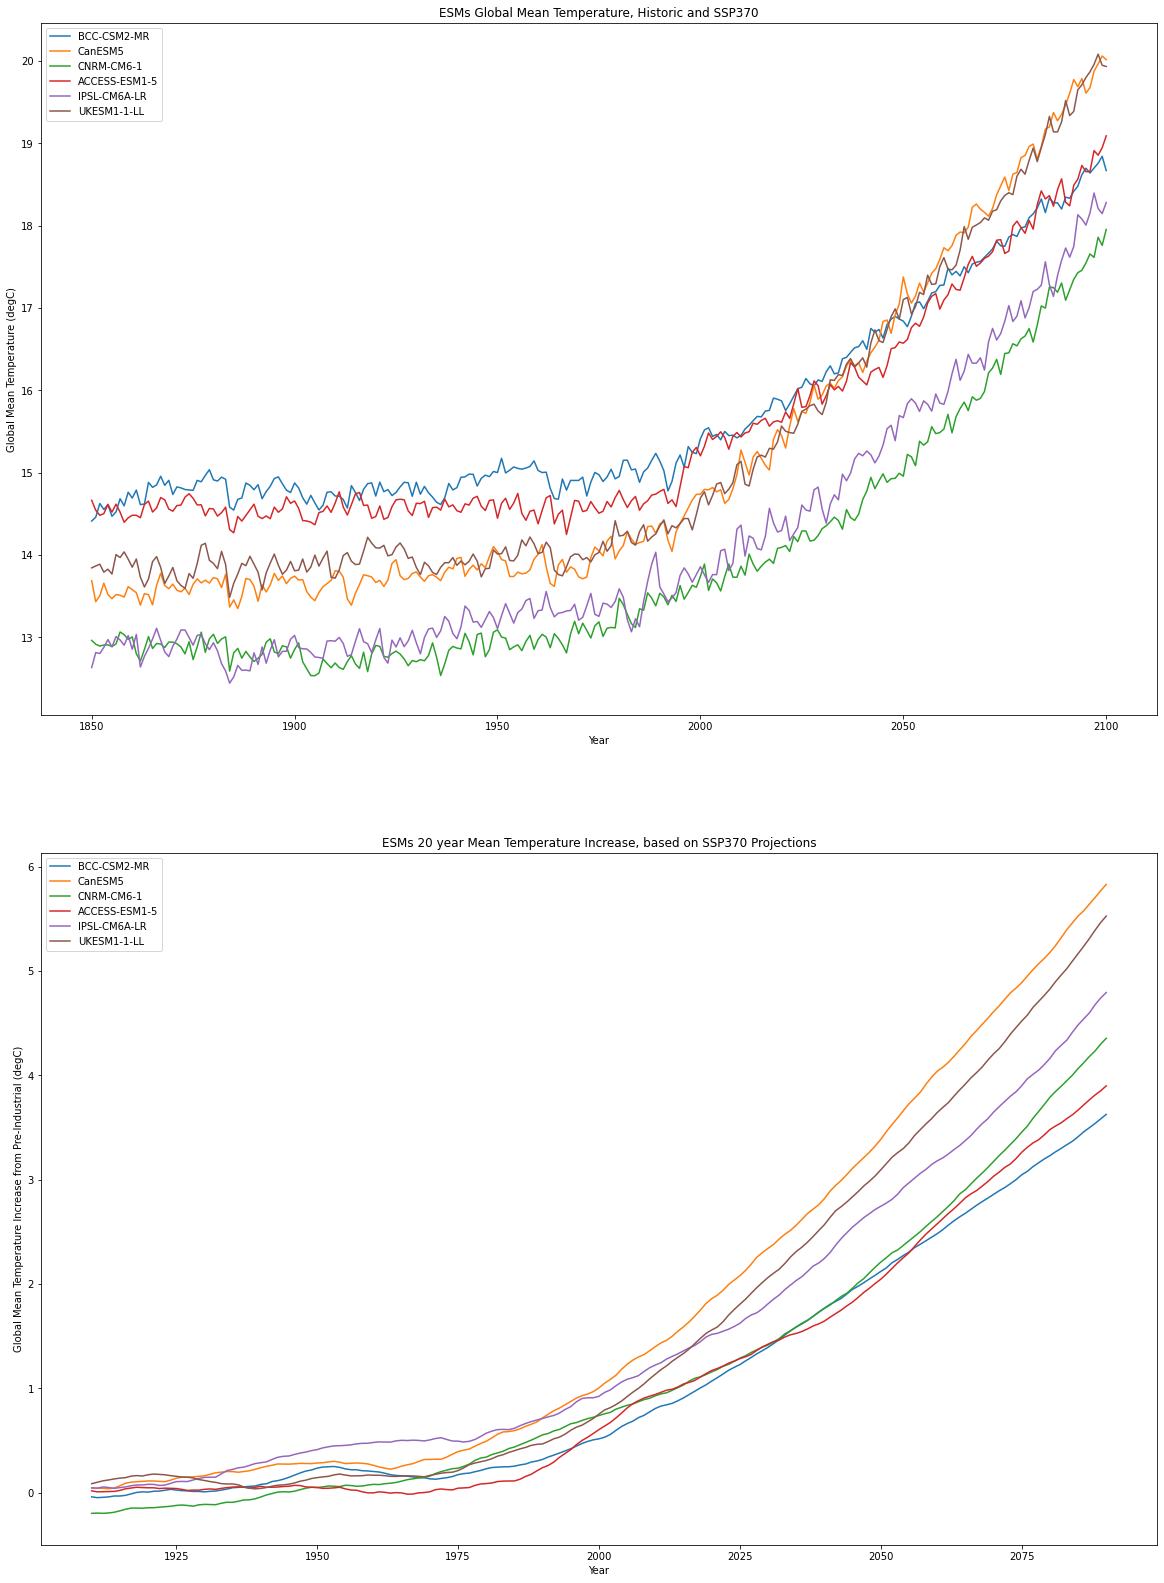

In [9]:
# get the historic 

# create axes to plot the model historic runs onto
fig, axes = plt.subplots(2,1, figsize = (20, 28))

pre_ind_means = []

for i in range(len(chosen_models_esm)):
#for i in range(1):
    model_centre = chosen_models_esm.model_centre[i]
    # reset the year_found to show the 2 degc rise has not been found yet 
    year_found = False
    year_found_1deg = False

    model = chosen_models_esm.model[i]
    variant = chosen_models_esm.variant[i]
    g_file = chosen_models_esm.g_file[i]

    #get the tas filepaths
    files = os.listdir('/badc/cmip6/data/CMIP6/CMIP/{}/{}/historical/{}/Amon/tas/{}/latest'.format(model_centre, model, variant, g_file))
    #print(len(file))
    #get arrays to add the data into, so for the ones which have separate files for years will be added in together
    years_all = np.array([], dtype='int64')
    glob_mean_tas_all= np.array([], dtype='float64') 
    for file in files:
        filepath_hist = '/badc/cmip6/data/CMIP6/CMIP/{}/{}/historical/{}/Amon/tas/{}/latest/{}'.format(model_centre, model, variant, g_file, file)
        ds = xr.open_dataset(filepath_hist)
        #get the mean global temp, based on https://gist.github.com/lgloege/3fdb1ed83b002d68d8944539a797b0bc#file-global_average_temperature-ipynb
        # area dataArray
        da_area = area_grid(ds['lat'], ds['lon'])
        # total area
        total_area = da_area.sum(['lat','lon'])
        # temperature weighted by grid-cell area
        temp_weighted = (ds['tas']*da_area) / total_area
        # area-weighted mean temperature
        temp_weighted_mean = temp_weighted.sum(['lat','lon'])
        # get the annual means
        annual_means = temp_weighted_mean.groupby('time.year').mean('time')
        years = annual_means['year'].values
        glob_mean_tas = annual_means.values
        #add them into the overall arrays
        years_all = np.concatenate([years_all, years])
        glob_mean_tas_all = np.concatenate([glob_mean_tas_all, glob_mean_tas])

    # add in the model projections (ssp370)
    files = os.listdir('/badc/cmip6/data/CMIP6/ScenarioMIP/{}/{}/ssp370/{}/Amon/tas/{}/latest/'.format(model_centre, model, variant, g_file))
        
    for file in files:
        filepath_ssp370 = '/badc/cmip6/data/CMIP6/ScenarioMIP/{}/{}/ssp370/{}/Amon/tas/{}/latest/{}'.format(model_centre, model, variant, g_file, file)
        ds = xr.open_dataset(filepath_ssp370)
        #get the mean global temp, based on https://gist.github.com/lgloege/3fdb1ed83b002d68d8944539a797b0bc#file-global_average_temperature-ipynb
        # area dataArray
        da_area = area_grid(ds['lat'], ds['lon'])
        # total area
        total_area = da_area.sum(['lat','lon'])
        # temperature weighted by grid-cell area
        temp_weighted = (ds['tas']*da_area) / total_area
        # area-weighted mean temperature
        temp_weighted_mean = temp_weighted.sum(['lat','lon'])
        # get the annual means
        annual_means = temp_weighted_mean.groupby('time.year').mean('time')
        years = annual_means['year'].values
        glob_mean_tas = annual_means.values
        #add them into the overall arrays
        years_all = np.concatenate([years_all, years])
        glob_mean_tas_all = np.concatenate([glob_mean_tas_all, glob_mean_tas])

    #have all the years now so get the pre industrial mean
    pre_industrial_mean_tas = glob_mean_tas_all[(years_all >= 1850) & (years_all< 1900)].mean()
    pre_ind_means.append(pre_industrial_mean_tas)
    
    # get 20 year averages - look at -10 years + 9 years from the year
    # start in 1910, end in 2090
    years_all
    glob_mean_tas_all[(years_all >= 1910) & (years_all< 2090)]
    
    # add the model to the plot of historic runs
    # set line style as dashed when it is 9+ as there are only 10 colors in cycle 
    if i >= 9:
        linestyle = 'dashed'
    else:
        linestyle = 'solid'
    axes[0].plot(years_all, glob_mean_tas_all - 273.15, label = model, linestyle = linestyle)

    # work out the 20 year means to find out what period the temperature rise from pre-industrial reaches 2deg C
    years_20_means = years_all[(years_all >= 1910) & (years_all<= 2090)]
    inc_20_means = []
    for year in years_20_means:
        temp_inc = glob_mean_tas_all[(years_all >= year -10 ) & (years_all<= year + 9)].mean() - pre_industrial_mean_tas
        if (temp_inc >=2) & (year_found == False):
            year_found = True 
            chosen_models_esm.loc[i, '2_deg_rise_year'] = year
        
        # get the years where warming has reached 1 degC
        if (temp_inc >=1) & (year_found_1deg == False):
            year_found_1deg = True
            chosen_models_esm.loc[i, '1_deg_rise_year'] = year
            
        inc_20_means.append(temp_inc)

    axes[1].plot(years_20_means, inc_20_means, label = model, linestyle = linestyle)
        
# add the legend and title to the final plots
axes[0].legend()
axes[0].set(title = 'ESMs Global Mean Temperature, Historic and SSP370', xlabel = 'Year', ylabel = 'Global Mean Temperature (degC)')

axes[1].legend()
axes[1].set(title = 'ESMs 20 year Mean Temperature Increase, based on SSP370 Projections', xlabel = 'Year', ylabel = 'Global Mean Temperature Increase from Pre-Industrial (degC)')

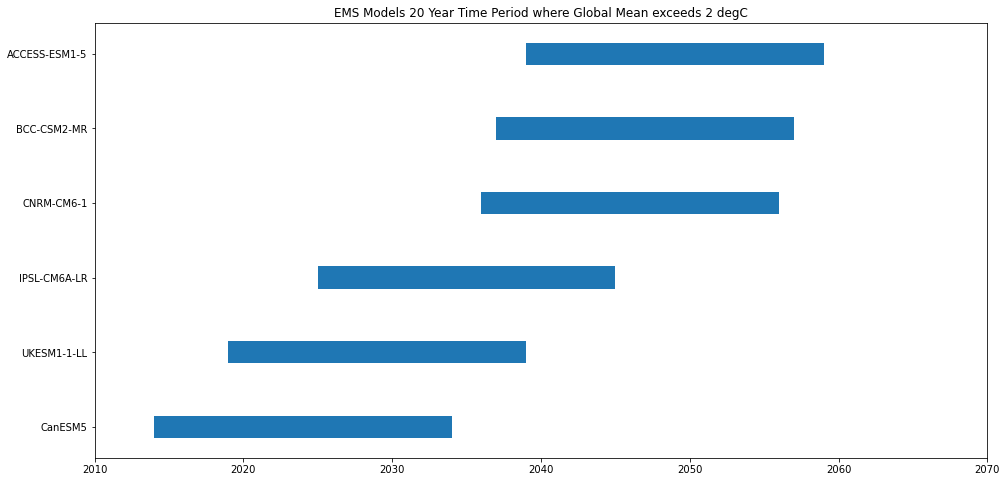

In [10]:
fig, axes = plt.subplots(1,1, figsize = (16,8))

start = chosen_models_esm.sort_values(['2_deg_rise_year'])['2_deg_rise_year'] - 10
end = chosen_models_esm.sort_values(['2_deg_rise_year'])['2_deg_rise_year'] + 10
yval = chosen_models_esm.sort_values(['2_deg_rise_year'])['model']
width = end-start

axes.barh(yval, width=width, left=start, height=0.3)
axes.set(title = 'EMS Models 20 Year Time Period where Global Mean exceeds 2 degC')
axes.set_xlim([2010, 2070])

plt.savefig('ESM_2_deg_time_period.png',bbox_inches='tight',facecolor='w')

In [12]:
# Create a df to save the esm lai projection info into 

# for the regridding mask the ocean (which are nans) as leaving them in leads to some cities having a nan lai

LAI_Proj_df = pd.DataFrame(columns = ['CITY_COUNTRY','City','Lat','Lon','Model','Month','LAI_Preind','LAI_2002_2020','LAI_Proj','LAI_Proj_1deg'
                                     ,'RH_Preind','RH_2002_2020','RH_Proj','RH_Proj_1deg','PR_Preind','PR_2002_2020','PR_Proj','PR_Proj_1deg'])
months = [1,2,3,4,5,6,7,8,9,10,11,12]

# get the base grid model and get the info for this one first
# As for the other models, this is the CanESM5
CanESM5_filepath_ssp370 = '/badc/cmip6/data/CMIP6/ScenarioMIP/CCCma/CanESM5/ssp370/r1i1p1f1/Lmon/lai/gn/latest/lai_Lmon_CanESM5_ssp370_r1i1p1f1_gn_201501-210012.nc'
CanESM5_ssp370_ds = xr.open_dataset(CanESM5_filepath_ssp370)

CanESM5_filepath_hist = '/badc/cmip6/data/CMIP6/CMIP/CCCma/CanESM5/historical/r1i1p1f1/Lmon/lai/gn/latest/lai_Lmon_CanESM5_historical_r1i1p1f1_gn_185001-201412.nc'
CanESM5_hist_ds = xr.open_dataset(CanESM5_filepath_hist)

# get the 20 year 2 degC warming timespan
model = 'CanESM5'
deg2_rise_year = chosen_models_esm[chosen_models_esm.model == model]['2_deg_rise_year'].values[0]
deg2_start_year = '{}-01-01'.format(int(deg2_rise_year - 10))
deg2_end_year = '{}-01-01'.format(int(deg2_rise_year + 10))

deg1_rise_year = chosen_models_esm[chosen_models_esm.model == model]['1_deg_rise_year'].values[0]
deg1_start_year = '{}-01-01'.format(int(deg1_rise_year - 10))
deg1_end_year = '{}-01-01'.format(int(deg1_rise_year + 10))


for city_i in range(len(CITY_COUNTRY_lat_lon)):
    city_lat = CITY_COUNTRY_lat_lon.Lat[city_i]
    city_lon = CITY_COUNTRY_lat_lon.Lon[city_i]
    CITY_COUNTRY = CITY_COUNTRY_lat_lon.CITY_COUNTRY[city_i]
    City = CITY_COUNTRY_lat_lon.City[city_i]
    City_LAI_Proj_df = pd.DataFrame(columns = ['CITY_COUNTRY','City','Lat','Lon','Model','Month','LAI_Preind','LAI_2002_2020','LAI_Proj','LAI_Proj_1deg'
                                               ,'RH_Preind','RH_2002_2020','RH_Proj','RH_Proj_1deg','PR_Preind','PR_2002_2020','PR_Proj','PR_Proj_1deg'] )

    if CanESM5_ssp370_ds.lon.max() > 300:
        city_lon = (city_lon + 360.0)%360.0

    ds_preind = CanESM5_hist_ds.sel(lat = city_lat, lon = city_lon, method="nearest").sel(time = slice('1850-01-01', '1900-01-01'))
    
    ds_2015_2020 = CanESM5_ssp370_ds.sel(lat = city_lat, lon = city_lon, method="nearest").sel(time = slice('2015-01-01', '2020-01-01'))
    ds_2002_2015 = CanESM5_hist_ds.sel(lat = city_lat, lon = city_lon, method="nearest").sel(time = slice('2002-01-01', '2015-01-01'))
    ds_2002_2020 = xr.merge([ds_2002_2015, ds_2015_2020])

    if (int(deg1_rise_year + 10) < 2015):
        ds_1deg = CanESM5_hist_ds.sel(lat = city_lat, lon = city_lon, method="nearest").sel(time = slice(deg1_start_year, deg1_end_year))
    elif (int(deg1_rise_year - 10) < 2015):
        ds_1deg_start = CanESM5_hist_ds.sel(lat = city_lat, lon = city_lon, method="nearest").sel(time = slice(deg1_start_year, '2015-01-01'))
        ds_1deg_end = CanESM5_ssp370_ds.sel(lat = city_lat, lon = city_lon, method="nearest").sel(time = slice('2015-01-01',deg1_end_year))
        ds_1deg =  xr.merge([ds_1deg_start, ds_1deg_end])
    else:
        ds_1deg = CanESM5_ssp370_ds.sel(lat = city_lat, lon = city_lon, method="nearest").sel(time = slice(deg1_start_year, deg1_end_year))
    
    ds_2deg = CanESM5_ssp370_ds.sel(lat = city_lat, lon = city_lon, method="nearest").sel(time = slice(deg2_start_year, deg2_end_year))

    LAI_2002_2020 = ds_2002_2020.groupby('time.month').mean('time')['lai'].values
    LAI_Proj = ds_2deg.groupby('time.month').mean('time')['lai'].values
    LAI_Proj_1deg = ds_1deg.groupby('time.month').mean('time')['lai'].values
    LAI_Preind = ds_preind.groupby('time.month').mean('time')['lai'].values
    
    City_LAI_Proj_df['Month'] = months
    City_LAI_Proj_df['LAI_Preind'] = LAI_Preind
    City_LAI_Proj_df['LAI_2002_2020'] = LAI_2002_2020
    City_LAI_Proj_df['LAI_Proj'] = LAI_Proj
    City_LAI_Proj_df['LAI_Proj_1deg'] = LAI_Proj_1deg
    City_LAI_Proj_df['Model'] = model
    City_LAI_Proj_df['CITY_COUNTRY'] = CITY_COUNTRY
    City_LAI_Proj_df['City'] = City
    City_LAI_Proj_df['Lat'] = CITY_COUNTRY_lat_lon.Lat[city_i]
    City_LAI_Proj_df['Lon'] = CITY_COUNTRY_lat_lon.Lon[city_i]

    LAI_Proj_df = pd.concat([LAI_Proj_df, City_LAI_Proj_df])

    # add in a masks for the base grids, as the lai is nan over the ocean
    CanESM5_ssp370_ds["mask"] = xr.where(~np.isnan(CanESM5_ssp370_ds["lai"].isel(time=0)), 1, 0)
    CanESM5_hist_ds["mask"] = xr.where(~np.isnan(CanESM5_hist_ds["lai"].isel(time=0)), 1, 0)
    
# now get for the rest of the models, which will need regridding 
for model in chosen_models_esm[chosen_models_esm.model != 'CanESM5'].model.values:

    model_centre = chosen_models_esm[chosen_models_esm.model == model].model_centre.values[0]
    variant = chosen_models_esm[chosen_models_esm.model == model].variant.values[0]
    g_file = chosen_models_esm[chosen_models_esm.model == model].g_file.values[0]
    deg2_rise_year = chosen_models_esm[chosen_models_esm.model == model]['2_deg_rise_year'].values[0]
    deg2_start_year = '{}-01-01'.format(int(deg2_rise_year - 10))
    deg2_end_year = '{}-01-01'.format(int(deg2_rise_year + 10))

    deg1_rise_year = chosen_models_esm[chosen_models_esm.model == model]['1_deg_rise_year'].values[0]
    deg1_start_year = '{}-01-01'.format(int(deg1_rise_year - 10))
    deg1_end_year = '{}-01-01'.format(int(deg1_rise_year + 10))
    
    #get the hurs datasets
    #historic
    if model_centre != '': # maybe add in the Earth consortium here
        files = os.listdir('/badc/cmip6/data/CMIP6/CMIP/{}/{}/historical/{}/Lmon/lai/{}/latest'.format(model_centre, model, variant, g_file))
        #open the first file, if there are separate files for years then merge them together
        if len(files) > 1:
            files2 = []
            for file in files:
                file_year_start = file[-16:-10]
                file_year_end = file[-9:-3]
                #if (int(file_year_end) < 200000):     # no point in getting info before 2000 as want to look from 2002
                files2.append(file) # add in all the files as now looking at preindustrial aswell as present day
    
            filepath_hist = '/badc/cmip6/data/CMIP6/CMIP/{}/{}/historical/{}/Lmon/lai/{}/latest/{}'.format(model_centre, model, variant, g_file, files2[0])
            # open the file
            ds = xr.load_dataset(filepath_hist)
            # regrid the file
            # Model with lowest resolution is CanESM5 at 2.8 x 2.8 degrees

            # add in a mask, as the lai is nan over the ocean
            ds["mask"] = xr.where(~np.isnan(ds["lai"].isel(time=0)), 1, 0)

            regrid = xe.Regridder(ds, CanESM5_ssp370_ds, method='conservative_normed', periodic=True)
            hist_ds = regrid(ds)
            

            
            for file in files2[1:]:
                filepath_hist = '/badc/cmip6/data/CMIP6/CMIP/{}/{}/historical/{}/Lmon/lai/{}/latest/{}'.format(model_centre, model, variant, g_file, file)
                # open the file
                ds2 = xr.load_dataset(filepath_hist)
                # add in a mask, as the lai is nan over the ocean
                ds2["mask"] = xr.where(~np.isnan(ds2["lai"].isel(time=0)), 1, 0)
                # regrid the file
                regrid_ds = regrid(ds2)

                
                #add the regridded files together
                hist_ds = xr.merge([hist_ds, regrid_ds])

        else:
            filepath_hist = '/badc/cmip6/data/CMIP6/CMIP/{}/{}/historical/{}/Lmon/lai/{}/latest/{}'.format(model_centre, model, variant, g_file, files[0])
            # open the file
            ds = xr.load_dataset(filepath_hist)
            # regrid the file
            # add in a mask, as the lai is nan over the ocean
            ds["mask"] = xr.where(~np.isnan(ds["lai"].isel(time=0)), 1, 0)
            # Model with lowest resolution is CanESM5 at 2.8 x 2.8 degrees
            regrid = xe.Regridder(ds, CanESM5_ssp370_ds, method='conservative_normed', periodic=True)
            hist_ds = regrid(ds)

            
    # ssp370 dataset
    files = os.listdir('/badc/cmip6/data/CMIP6/ScenarioMIP/{}/{}/ssp370/{}/Lmon/lai/{}/latest'.format(model_centre, model, variant, g_file))
    #open the first file, if there are separate files for years then merge them together
    if len(files) > 1:
        files2 = []
        for file in files:
            file_year_start = file[-16:-10]
            file_year_end = file[-9:-3]
            if (int(file_year_start) < int(deg2_rise_year + 10)*100): # no point in getting years which start after the time we are interested in 
                files2.append(file)
    
        filepath_ssp370 = '/badc/cmip6/data/CMIP6/ScenarioMIP/{}/{}/ssp370/{}/Lmon/lai/{}/latest/{}'.format(model_centre, model, variant, g_file, files2[0])
        # open the file
        ds = xr.load_dataset(filepath_ssp370)
        # regrid the file
        # add in a mask, as the lai is nan over the ocean
        ds["mask"] = xr.where(~np.isnan(ds["lai"].isel(time=0)), 1, 0)
        # Model with lowest resolution is CanESM5 at 2.8 x 2.8 degrees
        regrid = xe.Regridder(ds, CanESM5_ssp370_ds, method='conservative_normed', periodic=True)
        ssp370_ds = regrid(ds)
        
        for file in files2[1:]:
            filepath_ssp370 = '/badc/cmip6/data/CMIP6/ScenarioMIP/{}/{}/ssp370/{}/Lmon/lai/{}/latest/{}'.format(model_centre, model, variant, g_file, file)
            # open the file
            ds2 = xr.load_dataset(filepath_ssp370)
            # regrid the file
            # add in a mask, as the lai is nan over the ocean
            ds2["mask"] = xr.where(~np.isnan(ds2["lai"].isel(time=0)), 1, 0)
            regrid_ds = regrid(ds2)
            #add the regridded files together
            ssp370_ds = xr.merge([ssp370_ds, regrid_ds])

    
    else:
        filepath_ssp370 = '/badc/cmip6/data/CMIP6/ScenarioMIP/{}/{}/ssp370/{}/Lmon/lai/{}/latest/{}'.format(model_centre, model, variant, g_file, files[0])
        # open the file
        ds = xr.load_dataset(filepath_ssp370)
        # regrid the file
        # add in a mask, as the lai is nan over the ocean
        ds["mask"] = xr.where(~np.isnan(ds["lai"].isel(time=0)), 1, 0)
        # Model with lowest resolution is CanESM5 at 2.8 x 2.8 degrees
        regrid = xe.Regridder(ds, CanESM5_ssp370_ds, method='conservative_normed', periodic=True)
        ssp370_ds = regrid(ds)

    # loop through the cities and get the RH info

    for city_i in range(len(CITY_COUNTRY_lat_lon)):
        city_lat = CITY_COUNTRY_lat_lon.Lat[city_i]
        city_lon = CITY_COUNTRY_lat_lon.Lon[city_i]
        CITY_COUNTRY = CITY_COUNTRY_lat_lon.CITY_COUNTRY[city_i]
        City = CITY_COUNTRY_lat_lon.City[city_i]
        City_LAI_Proj_df = pd.DataFrame(columns = ['CITY_COUNTRY','City','Lat','Lon','Model','Month','LAI_Preind','LAI_2002_2020','LAI_Proj','LAI_Proj_1deg'
                                                  ,'RH_Preind','RH_2002_2020','RH_Proj','RH_Proj_1deg','PR_Preind','PR_2002_2020','PR_Proj','PR_Proj_1deg'])

        # convert the lons for ds where it is 0-360 (in the table they are -180 to 180)
        if ssp370_ds.lon.max() > 300:
            city_lon = (city_lon + 360.0)%360.0

        ds_preind = hist_ds.sel(lat = city_lat, lon = city_lon, method="nearest").sel(time = slice('1850-01-01', '1900-01-01'))
        
        ds_2015_2020 = ssp370_ds.sel(lat = city_lat, lon = city_lon, method="nearest").sel(time = slice('2015-01-01', '2020-01-01'))
        ds_2002_2015 = hist_ds.sel(lat = city_lat, lon = city_lon, method="nearest").sel(time = slice('2002-01-01', '2015-01-01'))
        ds_2002_2020 = xr.merge([ds_2002_2015, ds_2015_2020])

        if (int(deg1_rise_year + 10) < 2015):
            ds_1deg = hist_ds.sel(lat = city_lat, lon = city_lon, method="nearest").sel(time = slice(deg1_start_year, deg1_end_year))
        elif (int(deg1_rise_year - 10) < 2015):
            ds_1deg_start = hist_ds.sel(lat = city_lat, lon = city_lon, method="nearest").sel(time = slice(deg1_start_year, '2015-01-01'))
            ds_1deg_end = ssp370_ds.sel(lat = city_lat, lon = city_lon, method="nearest").sel(time = slice('2015-01-01',deg1_end_year))
            ds_1deg =  xr.merge([ds_1deg_start, ds_1deg_end])
        else:
            ds_1deg = ssp370_ds.sel(lat = city_lat, lon = city_lon, method="nearest").sel(time = slice(deg1_start_year, deg1_end_year))
        
        ds_2deg = ssp370_ds.sel(lat = city_lat, lon = city_lon, method="nearest").sel(time = slice(deg2_start_year, deg2_end_year))

        LAI_2002_2020 = ds_2002_2020.groupby('time.month').mean('time')['lai'].values
        LAI_Proj = ds_2deg.groupby('time.month').mean('time')['lai'].values
        LAI_Proj_1deg = ds_1deg.groupby('time.month').mean('time')['lai'].values
        LAI_Preind = ds_preind.groupby('time.month').mean('time')['lai'].values

        City_LAI_Proj_df['Month'] = months
        City_LAI_Proj_df['LAI_Preind'] = LAI_Preind
        City_LAI_Proj_df['LAI_2002_2020'] = LAI_2002_2020
        City_LAI_Proj_df['LAI_Proj'] = LAI_Proj
        City_LAI_Proj_df['LAI_Proj_1deg'] = LAI_Proj_1deg
        City_LAI_Proj_df['Model'] = model
        City_LAI_Proj_df['CITY_COUNTRY'] = CITY_COUNTRY
        City_LAI_Proj_df['City'] = City
        City_LAI_Proj_df['Lat'] = CITY_COUNTRY_lat_lon.Lat[city_i]
        City_LAI_Proj_df['Lon'] =  CITY_COUNTRY_lat_lon.Lon[city_i]

        LAI_Proj_df = pd.concat([LAI_Proj_df, City_LAI_Proj_df])
        
LAI_Proj_df = LAI_Proj_df.reset_index(drop = True)
with open('LAI_Proj_df.pkl', 'wb') as f:
    pickle.dump(LAI_Proj_df, f)

/home/users/sberk/.conda/envs/jupyterlabenv/lib/python3.9/site-packages/xesmf/backend.py:53: UserWarning: Latitude is outside of [-90, 90]
  warnings.warn('Latitude is outside of [-90, 90]')
/home/users/sberk/.conda/envs/jupyterlabenv/lib/python3.9/site-packages/xesmf/backend.py:53: UserWarning: Latitude is outside of [-90, 90]
  warnings.warn('Latitude is outside of [-90, 90]')


In [15]:
#########################################################################
######################## ADD IN RH AND PR ###############################
#########################################################################

##### PR #####

# Create a df to save the esm projection info into 
#LAI_Proj_df = pd.DataFrame(columns = ['CITY_COUNTRY','City','Lat','Lon','Model','Month','LAI_Preind','LAI_2002_2020','LAI_Proj','LAI_Proj_1deg'])
#months = [1,2,3,4,5,6,7,8,9,10,11,12]

# get the base grid model and get the info for this one first
# As for the other models, this is the CanESM5
CanESM5_filepath_ssp370 = '/badc/cmip6/data/CMIP6/ScenarioMIP/CCCma/CanESM5/ssp370/r1i1p1f1/Amon/pr/gn/latest/pr_Amon_CanESM5_ssp370_r1i1p1f1_gn_201501-210012.nc'
CanESM5_ssp370_ds = xr.open_dataset(CanESM5_filepath_ssp370)

CanESM5_filepath_hist = '/badc/cmip6/data/CMIP6/CMIP/CCCma/CanESM5/historical/r1i1p1f1/Amon/pr/gn/latest/pr_Amon_CanESM5_historical_r1i1p1f1_gn_185001-201412.nc'
CanESM5_hist_ds = xr.open_dataset(CanESM5_filepath_hist)

# get the 20 year 2 degC warming timespan
model = 'CanESM5'
deg2_rise_year = chosen_models_esm[chosen_models_esm.model == model]['2_deg_rise_year'].values[0]
deg2_start_year = '{}-01-01'.format(int(deg2_rise_year - 10))
deg2_end_year = '{}-01-01'.format(int(deg2_rise_year + 10))

deg1_rise_year = chosen_models_esm[chosen_models_esm.model == model]['1_deg_rise_year'].values[0]
deg1_start_year = '{}-01-01'.format(int(deg1_rise_year - 10))
deg1_end_year = '{}-01-01'.format(int(deg1_rise_year + 10))


for city_i in range(len(CITY_COUNTRY_lat_lon)):
    city_lat = CITY_COUNTRY_lat_lon.Lat[city_i]
    city_lon = CITY_COUNTRY_lat_lon.Lon[city_i]
    CITY_COUNTRY = CITY_COUNTRY_lat_lon.CITY_COUNTRY[city_i]
    City = CITY_COUNTRY_lat_lon.City[city_i]

    if CanESM5_ssp370_ds.lon.max() > 300:
        city_lon = (city_lon + 360.0)%360.0

    ds_preind = CanESM5_hist_ds.sel(lat = city_lat, lon = city_lon, method="nearest").sel(time = slice('1850-01-01', '1900-01-01'))
    
    ds_2015_2020 = CanESM5_ssp370_ds.sel(lat = city_lat, lon = city_lon, method="nearest").sel(time = slice('2015-01-01', '2020-01-01'))
    ds_2002_2015 = CanESM5_hist_ds.sel(lat = city_lat, lon = city_lon, method="nearest").sel(time = slice('2002-01-01', '2015-01-01'))
    ds_2002_2020 = xr.merge([ds_2002_2015, ds_2015_2020])

    if (int(deg1_rise_year + 10) < 2015):
        ds_1deg = CanESM5_hist_ds.sel(lat = city_lat, lon = city_lon, method="nearest").sel(time = slice(deg1_start_year, deg1_end_year))
    elif (int(deg1_rise_year - 10) < 2015):
        ds_1deg_start = CanESM5_hist_ds.sel(lat = city_lat, lon = city_lon, method="nearest").sel(time = slice(deg1_start_year, '2015-01-01'))
        ds_1deg_end = CanESM5_ssp370_ds.sel(lat = city_lat, lon = city_lon, method="nearest").sel(time = slice('2015-01-01',deg1_end_year))
        ds_1deg =  xr.merge([ds_1deg_start, ds_1deg_end])
    else:
        ds_1deg = CanESM5_ssp370_ds.sel(lat = city_lat, lon = city_lon, method="nearest").sel(time = slice(deg1_start_year, deg1_end_year))
    
    ds_2deg = CanESM5_ssp370_ds.sel(lat = city_lat, lon = city_lon, method="nearest").sel(time = slice(deg2_start_year, deg2_end_year))

    PR_2002_2020 = ds_2002_2020.groupby('time.month').mean('time')['pr'].values
    PR_Proj = ds_2deg.groupby('time.month').mean('time')['pr'].values
    PR_Proj_1deg = ds_1deg.groupby('time.month').mean('time')['pr'].values
    PR_Preind = ds_preind.groupby('time.month').mean('time')['pr'].values
    
    for x in range(len(months)):
        LAI_Proj_df.loc[(LAI_Proj_df.CITY_COUNTRY == CITY_COUNTRY) & (LAI_Proj_df.Model == model) & (LAI_Proj_df.Month == months[x]), 'PR_Preind'] = PR_Preind[x]
        LAI_Proj_df.loc[(LAI_Proj_df.CITY_COUNTRY == CITY_COUNTRY) & (LAI_Proj_df.Model == model) & (LAI_Proj_df.Month == months[x]), 'PR_2002_2020'] = PR_2002_2020[x]
        LAI_Proj_df.loc[(LAI_Proj_df.CITY_COUNTRY == CITY_COUNTRY) & (LAI_Proj_df.Model == model) & (LAI_Proj_df.Month == months[x]), 'PR_Proj'] = PR_Proj[x] 
        LAI_Proj_df.loc[(LAI_Proj_df.CITY_COUNTRY == CITY_COUNTRY) & (LAI_Proj_df.Model == model) & (LAI_Proj_df.Month == months[x]), 'PR_Proj_1deg'] = PR_Proj_1deg[x]

# now get for the rest of the models, which will need regridding 
for model in chosen_models_esm[chosen_models_esm.model != 'CanESM5'].model.values:

    model_centre = chosen_models_esm[chosen_models_esm.model == model].model_centre.values[0]
    variant = chosen_models_esm[chosen_models_esm.model == model].variant.values[0]
    g_file = chosen_models_esm[chosen_models_esm.model == model].g_file.values[0]
    deg2_rise_year = chosen_models_esm[chosen_models_esm.model == model]['2_deg_rise_year'].values[0]
    deg2_start_year = '{}-01-01'.format(int(deg2_rise_year - 10))
    deg2_end_year = '{}-01-01'.format(int(deg2_rise_year + 10))

    deg1_rise_year = chosen_models_esm[chosen_models_esm.model == model]['1_deg_rise_year'].values[0]
    deg1_start_year = '{}-01-01'.format(int(deg1_rise_year - 10))
    deg1_end_year = '{}-01-01'.format(int(deg1_rise_year + 10))
    
    #get the hurs datasets
    #historic
    if model_centre != '': # maybe add in the Earth consortium here
        files = os.listdir('/badc/cmip6/data/CMIP6/CMIP/{}/{}/historical/{}/Amon/pr/{}/latest'.format(model_centre, model, variant, g_file))
        #open the first file, if there are separate files for years then merge them together
        if len(files) > 1:
            files2 = []
            for file in files:
                file_year_start = file[-16:-10]
                file_year_end = file[-9:-3]
                #if (int(file_year_end) < 200000):     # no point in getting info before 2000 as want to look from 2002
                files2.append(file) # add in all the files as now looking at preindustrial aswell as present day
    
            filepath_hist = '/badc/cmip6/data/CMIP6/CMIP/{}/{}/historical/{}/Amon/pr/{}/latest/{}'.format(model_centre, model, variant, g_file, files2[0])
            # open the file
            ds = xr.load_dataset(filepath_hist)
            # regrid the file
            # Model with lowest resolution is CanESM5 at 2.8 x 2.8 degrees
            regrid = xe.Regridder(ds, CanESM5_ssp370_ds, method='conservative', periodic=True)
            hist_ds = regrid(ds)
            for file in files2[1:]:
                filepath_hist = '/badc/cmip6/data/CMIP6/CMIP/{}/{}/historical/{}/Amon/pr/{}/latest/{}'.format(model_centre, model, variant, g_file, file)
                # open the file
                ds2 = xr.load_dataset(filepath_hist)
                # regrid the file
                regrid_ds = regrid(ds2)
                #add the regridded files together
                hist_ds = xr.merge([hist_ds, regrid_ds])

        else:
            filepath_hist = '/badc/cmip6/data/CMIP6/CMIP/{}/{}/historical/{}/Amon/pr/{}/latest/{}'.format(model_centre, model, variant, g_file, files[0])
            # open the file
            ds = xr.load_dataset(filepath_hist)
            # regrid the file
            # Model with lowest resolution is CanESM5 at 2.8 x 2.8 degrees
            regrid = xe.Regridder(ds, CanESM5_ssp370_ds, method='conservative', periodic=True)
            hist_ds = regrid(ds)

            
    # ssp370 dataset
    files = os.listdir('/badc/cmip6/data/CMIP6/ScenarioMIP/{}/{}/ssp370/{}/Amon/pr/{}/latest'.format(model_centre, model, variant, g_file))
    #open the first file, if there are separate files for years then merge them together
    if len(files) > 1:
        files2 = []
        for file in files:
            file_year_start = file[-16:-10]
            file_year_end = file[-9:-3]
            if (int(file_year_start) < int(deg2_rise_year + 10)*100): # no point in getting years which start after the time we are interested in 
                files2.append(file)
    
        filepath_ssp370 = '/badc/cmip6/data/CMIP6/ScenarioMIP/{}/{}/ssp370/{}/Amon/pr/{}/latest/{}'.format(model_centre, model, variant, g_file, files2[0])
        # open the file
        ds = xr.load_dataset(filepath_ssp370)
        # regrid the file
        # Model with lowest resolution is CanESM5 at 2.8 x 2.8 degrees
        regrid = xe.Regridder(ds, CanESM5_ssp370_ds, method='conservative', periodic=True)
        ssp370_ds = regrid(ds)
        for file in files2[1:]:
            filepath_ssp370 = '/badc/cmip6/data/CMIP6/ScenarioMIP/{}/{}/ssp370/{}/Amon/pr/{}/latest/{}'.format(model_centre, model, variant, g_file, file)
            # open the file
            ds2 = xr.load_dataset(filepath_ssp370)
            # regrid the file
            regrid_ds = regrid(ds2)
            #add the regridded files together
            ssp370_ds = xr.merge([ssp370_ds, regrid_ds])

    else:
        filepath_ssp370 = '/badc/cmip6/data/CMIP6/ScenarioMIP/{}/{}/ssp370/{}/Amon/pr/{}/latest/{}'.format(model_centre, model, variant, g_file, files[0])
        # open the file
        ds = xr.load_dataset(filepath_ssp370)
        # regrid the file
        # Model with lowest resolution is CanESM5 at 2.8 x 2.8 degrees
        regrid = xe.Regridder(ds, CanESM5_ssp370_ds, method='conservative', periodic=True)
        ssp370_ds = regrid(ds)

    # loop through the cities and get the RH info

    for city_i in range(len(CITY_COUNTRY_lat_lon)):
        city_lat = CITY_COUNTRY_lat_lon.Lat[city_i]
        city_lon = CITY_COUNTRY_lat_lon.Lon[city_i]
        CITY_COUNTRY = CITY_COUNTRY_lat_lon.CITY_COUNTRY[city_i]
        City = CITY_COUNTRY_lat_lon.City[city_i]

        # convert the lons for ds where it is 0-360 (in the table they are -180 to 180)
        if ssp370_ds.lon.max() > 300:
            city_lon = (city_lon + 360.0)%360.0

        ds_preind = hist_ds.sel(lat = city_lat, lon = city_lon, method="nearest").sel(time = slice('1850-01-01', '1900-01-01'))
        
        ds_2015_2020 = ssp370_ds.sel(lat = city_lat, lon = city_lon, method="nearest").sel(time = slice('2015-01-01', '2020-01-01'))
        ds_2002_2015 = hist_ds.sel(lat = city_lat, lon = city_lon, method="nearest").sel(time = slice('2002-01-01', '2015-01-01'))
        ds_2002_2020 = xr.merge([ds_2002_2015, ds_2015_2020])

        if (int(deg1_rise_year + 10) < 2015):
            ds_1deg = hist_ds.sel(lat = city_lat, lon = city_lon, method="nearest").sel(time = slice(deg1_start_year, deg1_end_year))
        elif (int(deg1_rise_year - 10) < 2015):
            ds_1deg_start = hist_ds.sel(lat = city_lat, lon = city_lon, method="nearest").sel(time = slice(deg1_start_year, '2015-01-01'))
            ds_1deg_end = ssp370_ds.sel(lat = city_lat, lon = city_lon, method="nearest").sel(time = slice('2015-01-01',deg1_end_year))
            ds_1deg =  xr.merge([ds_1deg_start, ds_1deg_end])
        else:
            ds_1deg = ssp370_ds.sel(lat = city_lat, lon = city_lon, method="nearest").sel(time = slice(deg1_start_year, deg1_end_year))
        
        ds_2deg = ssp370_ds.sel(lat = city_lat, lon = city_lon, method="nearest").sel(time = slice(deg2_start_year, deg2_end_year))

        PR_2002_2020 = ds_2002_2020.groupby('time.month').mean('time')['pr'].values
        PR_Proj = ds_2deg.groupby('time.month').mean('time')['pr'].values
        PR_Proj_1deg = ds_1deg.groupby('time.month').mean('time')['pr'].values
        PR_Preind = ds_preind.groupby('time.month').mean('time')['pr'].values

        for x in range(len(months)):
            LAI_Proj_df.loc[(LAI_Proj_df.CITY_COUNTRY == CITY_COUNTRY) & (LAI_Proj_df.Model == model) & (LAI_Proj_df.Month == months[x]), 'PR_Preind'] = PR_Preind[x]
            LAI_Proj_df.loc[(LAI_Proj_df.CITY_COUNTRY == CITY_COUNTRY) & (LAI_Proj_df.Model == model) & (LAI_Proj_df.Month == months[x]), 'PR_2002_2020'] = PR_2002_2020[x]
            LAI_Proj_df.loc[(LAI_Proj_df.CITY_COUNTRY == CITY_COUNTRY) & (LAI_Proj_df.Model == model) & (LAI_Proj_df.Month == months[x]), 'PR_Proj'] = PR_Proj[x]
            LAI_Proj_df.loc[(LAI_Proj_df.CITY_COUNTRY == CITY_COUNTRY) & (LAI_Proj_df.Model == model) & (LAI_Proj_df.Month == months[x]), 'PR_Proj_1deg'] = PR_Proj_1deg[x]

# convert the PR from prep flux to mm/day     
LAI_Proj_df['PR_Preind'] = 24*60*60*LAI_Proj_df['PR_Preind']
LAI_Proj_df['PR_2002_2020'] = 24*60*60*LAI_Proj_df['PR_2002_2020']
LAI_Proj_df['PR_Proj'] = 24*60*60*LAI_Proj_df['PR_Proj'] 
LAI_Proj_df['PR_Proj_1deg'] = 24*60*60*LAI_Proj_df['PR_Proj_1deg'] 

with open('LAI_Proj_df.pkl', 'wb') as f:
    pickle.dump(LAI_Proj_df, f)

/home/users/sberk/.conda/envs/jupyterlabenv/lib/python3.9/site-packages/xesmf/backend.py:53: UserWarning: Latitude is outside of [-90, 90]
  warnings.warn('Latitude is outside of [-90, 90]')
/home/users/sberk/.conda/envs/jupyterlabenv/lib/python3.9/site-packages/xesmf/backend.py:53: UserWarning: Latitude is outside of [-90, 90]
  warnings.warn('Latitude is outside of [-90, 90]')


In [17]:
##### RH #####

# get the base grid model and get the info for this one first
# As for the other models, this is the CanESM5
CanESM5_filepath_ssp370 = '/badc/cmip6/data/CMIP6/ScenarioMIP/CCCma/CanESM5/ssp370/r1i1p1f1/Amon/hurs/gn/latest/hurs_Amon_CanESM5_ssp370_r1i1p1f1_gn_201501-210012.nc'
CanESM5_ssp370_ds = xr.open_dataset(CanESM5_filepath_ssp370)

CanESM5_filepath_hist = '/badc/cmip6/data/CMIP6/CMIP/CCCma/CanESM5/historical/r1i1p1f1/Amon/hurs/gn/latest/hurs_Amon_CanESM5_historical_r1i1p1f1_gn_185001-201412.nc'
CanESM5_hist_ds = xr.open_dataset(CanESM5_filepath_hist)

# get the 20 year 2 degC warming timespan
model = 'CanESM5'
deg2_rise_year = chosen_models_esm[chosen_models_esm.model == model]['2_deg_rise_year'].values[0]
deg2_start_year = '{}-01-01'.format(int(deg2_rise_year - 10))
deg2_end_year = '{}-01-01'.format(int(deg2_rise_year + 10))

deg1_rise_year = chosen_models_esm[chosen_models_esm.model == model]['1_deg_rise_year'].values[0]
deg1_start_year = '{}-01-01'.format(int(deg1_rise_year - 10))
deg1_end_year = '{}-01-01'.format(int(deg1_rise_year + 10))


for city_i in range(len(CITY_COUNTRY_lat_lon)):
    city_lat = CITY_COUNTRY_lat_lon.Lat[city_i]
    city_lon = CITY_COUNTRY_lat_lon.Lon[city_i]
    CITY_COUNTRY = CITY_COUNTRY_lat_lon.CITY_COUNTRY[city_i]
    City = CITY_COUNTRY_lat_lon.City[city_i]

    if CanESM5_ssp370_ds.lon.max() > 300:
        city_lon = (city_lon + 360.0)%360.0

    ds_preind = CanESM5_hist_ds.sel(lat = city_lat, lon = city_lon, method="nearest").sel(time = slice('1850-01-01', '1900-01-01'))
    
    ds_2015_2020 = CanESM5_ssp370_ds.sel(lat = city_lat, lon = city_lon, method="nearest").sel(time = slice('2015-01-01', '2020-01-01'))
    ds_2002_2015 = CanESM5_hist_ds.sel(lat = city_lat, lon = city_lon, method="nearest").sel(time = slice('2002-01-01', '2015-01-01'))
    ds_2002_2020 = xr.merge([ds_2002_2015, ds_2015_2020])

    if (int(deg1_rise_year + 10) < 2015):
        ds_1deg = CanESM5_hist_ds.sel(lat = city_lat, lon = city_lon, method="nearest").sel(time = slice(deg1_start_year, deg1_end_year))
    elif (int(deg1_rise_year - 10) < 2015):
        ds_1deg_start = CanESM5_hist_ds.sel(lat = city_lat, lon = city_lon, method="nearest").sel(time = slice(deg1_start_year, '2015-01-01'))
        ds_1deg_end = CanESM5_ssp370_ds.sel(lat = city_lat, lon = city_lon, method="nearest").sel(time = slice('2015-01-01',deg1_end_year))
        ds_1deg =  xr.merge([ds_1deg_start, ds_1deg_end])
    else:
        ds_1deg = CanESM5_ssp370_ds.sel(lat = city_lat, lon = city_lon, method="nearest").sel(time = slice(deg1_start_year, deg1_end_year))
    
    ds_2deg = CanESM5_ssp370_ds.sel(lat = city_lat, lon = city_lon, method="nearest").sel(time = slice(deg2_start_year, deg2_end_year))

    RH_2002_2020 = ds_2002_2020.groupby('time.month').mean('time')['hurs'].values
    RH_Proj = ds_2deg.groupby('time.month').mean('time')['hurs'].values
    RH_Proj_1deg = ds_1deg.groupby('time.month').mean('time')['hurs'].values
    RH_Preind = ds_preind.groupby('time.month').mean('time')['hurs'].values
    
    for x in range(len(months)):
        LAI_Proj_df.loc[(LAI_Proj_df.CITY_COUNTRY == CITY_COUNTRY) & (LAI_Proj_df.Model == model) & (LAI_Proj_df.Month == months[x]), 'RH_Preind'] = RH_Preind[x]
        LAI_Proj_df.loc[(LAI_Proj_df.CITY_COUNTRY == CITY_COUNTRY) & (LAI_Proj_df.Model == model) & (LAI_Proj_df.Month == months[x]), 'RH_2002_2020'] = RH_2002_2020[x]
        LAI_Proj_df.loc[(LAI_Proj_df.CITY_COUNTRY == CITY_COUNTRY) & (LAI_Proj_df.Model == model) & (LAI_Proj_df.Month == months[x]), 'RH_Proj'] = RH_Proj[x] 
        LAI_Proj_df.loc[(LAI_Proj_df.CITY_COUNTRY == CITY_COUNTRY) & (LAI_Proj_df.Model == model) & (LAI_Proj_df.Month == months[x]), 'RH_Proj_1deg'] = RH_Proj_1deg[x]

# now get for the rest of the models, which will need regridding 
for model in chosen_models_esm[(chosen_models_esm.model != 'CanESM5')&(chosen_models_esm.model != 'BCC-CSM2-MR')].model.values:

    model_centre = chosen_models_esm[chosen_models_esm.model == model].model_centre.values[0]
    variant = chosen_models_esm[chosen_models_esm.model == model].variant.values[0]
    g_file = chosen_models_esm[chosen_models_esm.model == model].g_file.values[0]
    deg2_rise_year = chosen_models_esm[chosen_models_esm.model == model]['2_deg_rise_year'].values[0]
    deg2_start_year = '{}-01-01'.format(int(deg2_rise_year - 10))
    deg2_end_year = '{}-01-01'.format(int(deg2_rise_year + 10))

    deg1_rise_year = chosen_models_esm[chosen_models_esm.model == model]['1_deg_rise_year'].values[0]
    deg1_start_year = '{}-01-01'.format(int(deg1_rise_year - 10))
    deg1_end_year = '{}-01-01'.format(int(deg1_rise_year + 10))
    
    #get the hurs datasets
    #historic
    if model_centre != '': # maybe add in the Earth consortium here
        files = os.listdir('/badc/cmip6/data/CMIP6/CMIP/{}/{}/historical/{}/Amon/hurs/{}/latest'.format(model_centre, model, variant, g_file))
        #open the first file, if there are separate files for years then merge them together
        if len(files) > 1:
            files2 = []
            for file in files:
                file_year_start = file[-16:-10]
                file_year_end = file[-9:-3]
                #if (int(file_year_end) < 200000):     # no point in getting info before 2000 as want to look from 2002
                files2.append(file) # add in all the files as now looking at preindustrial aswell as present day
    
            filepath_hist = '/badc/cmip6/data/CMIP6/CMIP/{}/{}/historical/{}/Amon/hurs/{}/latest/{}'.format(model_centre, model, variant, g_file, files2[0])
            # open the file
            ds = xr.load_dataset(filepath_hist)
            # regrid the file
            # Model with lowest resolution is CanESM5 at 2.8 x 2.8 degrees
            regrid = xe.Regridder(ds, CanESM5_ssp370_ds, method='conservative', periodic=True)
            hist_ds = regrid(ds)
            for file in files2[1:]:
                filepath_hist = '/badc/cmip6/data/CMIP6/CMIP/{}/{}/historical/{}/Amon/hurs/{}/latest/{}'.format(model_centre, model, variant, g_file, file)
                # open the file
                ds2 = xr.load_dataset(filepath_hist)
                # regrid the file
                regrid_ds = regrid(ds2)
                #add the regridded files together
                hist_ds = xr.merge([hist_ds, regrid_ds])

        else:
            filepath_hist = '/badc/cmip6/data/CMIP6/CMIP/{}/{}/historical/{}/Amon/hurs/{}/latest/{}'.format(model_centre, model, variant, g_file, files[0])
            # open the file
            ds = xr.load_dataset(filepath_hist)
            # regrid the file
            # Model with lowest resolution is CanESM5 at 2.8 x 2.8 degrees
            regrid = xe.Regridder(ds, CanESM5_ssp370_ds, method='conservative', periodic=True)
            hist_ds = regrid(ds)

  
    # ssp370 dataset
    files = os.listdir('/badc/cmip6/data/CMIP6/ScenarioMIP/{}/{}/ssp370/{}/Amon/hurs/{}/latest'.format(model_centre, model, variant, g_file))
    #open the first file, if there are separate files for years then merge them together
    if len(files) > 1:
        files2 = []
        for file in files:
            file_year_start = file[-16:-10]
            file_year_end = file[-9:-3]
            if (int(file_year_start) < int(deg2_rise_year + 10)*100): # no point in getting years which start after the time we are interested in 
                files2.append(file)
    
        filepath_ssp370 = '/badc/cmip6/data/CMIP6/ScenarioMIP/{}/{}/ssp370/{}/Amon/hurs/{}/latest/{}'.format(model_centre, model, variant, g_file, files2[0])
        # open the file
        ds = xr.load_dataset(filepath_ssp370)
        # regrid the file
        # Model with lowest resolution is CanESM5 at 2.8 x 2.8 degrees
        regrid = xe.Regridder(ds, CanESM5_ssp370_ds, method='conservative', periodic=True)
        ssp370_ds = regrid(ds)
        for file in files2[1:]:
            filepath_ssp370 = '/badc/cmip6/data/CMIP6/ScenarioMIP/{}/{}/ssp370/{}/Amon/hurs/{}/latest/{}'.format(model_centre, model, variant, g_file, file)
            # open the file
            ds2 = xr.load_dataset(filepath_ssp370)
            # regrid the file
            regrid_ds = regrid(ds2)
            #add the regridded files together
            ssp370_ds = xr.merge([ssp370_ds, regrid_ds])

    else:
        filepath_ssp370 = '/badc/cmip6/data/CMIP6/ScenarioMIP/{}/{}/ssp370/{}/Amon/hurs/{}/latest/{}'.format(model_centre, model, variant, g_file, files[0])
        # open the file
        ds = xr.load_dataset(filepath_ssp370)
        # regrid the file
        # Model with lowest resolution is CanESM5 at 2.8 x 2.8 degrees 
        regrid = xe.Regridder(ds, CanESM5_ssp370_ds, method='conservative', periodic=True)
        ssp370_ds = regrid(ds)

    # loop through the cities and get the RH info

    for city_i in range(len(CITY_COUNTRY_lat_lon)):
        city_lat = CITY_COUNTRY_lat_lon.Lat[city_i]
        city_lon = CITY_COUNTRY_lat_lon.Lon[city_i]
        CITY_COUNTRY = CITY_COUNTRY_lat_lon.CITY_COUNTRY[city_i]
        City = CITY_COUNTRY_lat_lon.City[city_i]

        # convert the lons for ds where it is 0-360 (in the table they are -180 to 180)
        if ssp370_ds.lon.max() > 300:
            city_lon = (city_lon + 360.0)%360.0

        ds_preind = hist_ds.sel(lat = city_lat, lon = city_lon, method="nearest").sel(time = slice('1850-01-01', '1900-01-01'))
        
        ds_2015_2020 = ssp370_ds.sel(lat = city_lat, lon = city_lon, method="nearest").sel(time = slice('2015-01-01', '2020-01-01'))
        ds_2002_2015 = hist_ds.sel(lat = city_lat, lon = city_lon, method="nearest").sel(time = slice('2002-01-01', '2015-01-01'))
        ds_2002_2020 = xr.merge([ds_2002_2015, ds_2015_2020])

        if (int(deg1_rise_year + 10) < 2015):
            ds_1deg = hist_ds.sel(lat = city_lat, lon = city_lon, method="nearest").sel(time = slice(deg1_start_year, deg1_end_year))
        elif (int(deg1_rise_year - 10) < 2015):
            ds_1deg_start = hist_ds.sel(lat = city_lat, lon = city_lon, method="nearest").sel(time = slice(deg1_start_year, '2015-01-01'))
            ds_1deg_end = ssp370_ds.sel(lat = city_lat, lon = city_lon, method="nearest").sel(time = slice('2015-01-01',deg1_end_year))
            ds_1deg =  xr.merge([ds_1deg_start, ds_1deg_end])
        else:
            ds_1deg = ssp370_ds.sel(lat = city_lat, lon = city_lon, method="nearest").sel(time = slice(deg1_start_year, deg1_end_year))
        
        ds_2deg = ssp370_ds.sel(lat = city_lat, lon = city_lon, method="nearest").sel(time = slice(deg2_start_year, deg2_end_year))

        RH_2002_2020 = ds_2002_2020.groupby('time.month').mean('time')['hurs'].values
        RH_Proj = ds_2deg.groupby('time.month').mean('time')['hurs'].values
        RH_Proj_1deg = ds_1deg.groupby('time.month').mean('time')['hurs'].values
        RH_Preind = ds_preind.groupby('time.month').mean('time')['hurs'].values

        for x in range(len(months)):
            LAI_Proj_df.loc[(LAI_Proj_df.CITY_COUNTRY == CITY_COUNTRY) & (LAI_Proj_df.Model == model) & (LAI_Proj_df.Month == months[x]), 'RH_Preind'] = RH_Preind[x]
            LAI_Proj_df.loc[(LAI_Proj_df.CITY_COUNTRY == CITY_COUNTRY) & (LAI_Proj_df.Model == model) & (LAI_Proj_df.Month == months[x]), 'RH_2002_2020'] = RH_2002_2020[x]
            LAI_Proj_df.loc[(LAI_Proj_df.CITY_COUNTRY == CITY_COUNTRY) & (LAI_Proj_df.Model == model) & (LAI_Proj_df.Month == months[x]), 'RH_Proj'] = RH_Proj[x]
            LAI_Proj_df.loc[(LAI_Proj_df.CITY_COUNTRY == CITY_COUNTRY) & (LAI_Proj_df.Model == model) & (LAI_Proj_df.Month == months[x]), 'RH_Proj_1deg'] = RH_Proj_1deg[x]

with open('LAI_Proj_df.pkl', 'wb') as f:
    pickle.dump(LAI_Proj_df, f)

/home/users/sberk/.conda/envs/jupyterlabenv/lib/python3.9/site-packages/xesmf/backend.py:53: UserWarning: Latitude is outside of [-90, 90]
  warnings.warn('Latitude is outside of [-90, 90]')
/home/users/sberk/.conda/envs/jupyterlabenv/lib/python3.9/site-packages/xesmf/backend.py:53: UserWarning: Latitude is outside of [-90, 90]
  warnings.warn('Latitude is outside of [-90, 90]')


In [76]:
##### LST (Surface Skin Temperature) #####

## ts ##

## mask the sea as don't want sea surface temperature
# for this, get the lai dataset also to use as a mask

# for the regridding mask the ocean (which are nans) as leaving them in leads to some cities having a nan lai

LST_Proj_df = pd.DataFrame(columns = ['CITY_COUNTRY','City','Lat','Lon','Model','Month',
                                      'LST_Preind','LST_2002_2020','LST_Proj'])
months = [1,2,3,4,5,6,7,8,9,10,11,12]

# get the base grid model and get the info for this one first
# As for the other models, this is the CanESM5
CanESM5_filepath_ssp370 = '/badc/cmip6/data/CMIP6/ScenarioMIP/CCCma/CanESM5/ssp370/r1i1p1f1/Amon/ts/gn/latest/ts_Amon_CanESM5_ssp370_r1i1p1f1_gn_201501-210012.nc'
CanESM5_ssp370_ds = xr.open_dataset(CanESM5_filepath_ssp370)

CanESM5_filepath_hist = '/badc/cmip6/data/CMIP6/CMIP/CCCma/CanESM5/historical/r1i1p1f1/Amon/ts/gn/latest/ts_Amon_CanESM5_historical_r1i1p1f1_gn_185001-201412.nc'
CanESM5_hist_ds = xr.open_dataset(CanESM5_filepath_hist)

masking_filepath = '/badc/cmip6/data/CMIP6/ScenarioMIP/CCCma/CanESM5/ssp370/r1i1p1f1/Lmon/lai/gn/latest/lai_Lmon_CanESM5_ssp370_r1i1p1f1_gn_201501-210012.nc'
masking_ds = xr.open_dataset(masking_filepath)

# get the 20 year 2 degC warming timespan
model = 'CanESM5'
deg2_rise_year = chosen_models_esm[chosen_models_esm.model == model]['2_deg_rise_year'].values[0]
deg2_start_year = '{}-01-01'.format(int(deg2_rise_year - 10))
deg2_end_year = '{}-01-01'.format(int(deg2_rise_year + 10))

deg1_rise_year = chosen_models_esm[chosen_models_esm.model == model]['1_deg_rise_year'].values[0]
deg1_start_year = '{}-01-01'.format(int(deg1_rise_year - 10))
deg1_end_year = '{}-01-01'.format(int(deg1_rise_year + 10))

for city_i in range(len(CITY_COUNTRY_lat_lon)):
    city_lat = CITY_COUNTRY_lat_lon.Lat[city_i]
    city_lon = CITY_COUNTRY_lat_lon.Lon[city_i]
    CITY_COUNTRY = CITY_COUNTRY_lat_lon.CITY_COUNTRY[city_i]
    City = CITY_COUNTRY_lat_lon.City[city_i]
    City_LST_Proj_df =  pd.DataFrame(columns = ['CITY_COUNTRY','City','Lat','Lon','Model','Month',
                                      'LST_Preind','LST_2002_2020','LST_Proj'])
    if CanESM5_ssp370_ds.lon.max() > 300:
        city_lon = (city_lon + 360.0)%360.0

    city_masking_ds = masking_ds.sel(lat = city_lat, lon = city_lon, method="nearest")
    
    ds_preind = CanESM5_hist_ds.sel(lat = city_lat, lon = city_lon, method="nearest").sel(
                                    time = slice('1850-01-01', '1900-01-01'))
    
    ds_2015_2020 = CanESM5_ssp370_ds.sel(lat = city_lat, lon = city_lon, method="nearest").sel(time = slice('2015-01-01', '2020-01-01'))
    ds_2002_2015 = CanESM5_hist_ds.sel(lat = city_lat, lon = city_lon, method="nearest").sel(time = slice('2002-01-01', '2015-01-01'))
    ds_2002_2020 = xr.merge([ds_2002_2015, ds_2015_2020])

   
    ds_2deg = CanESM5_ssp370_ds.sel(lat = city_lat, lon = city_lon, method="nearest").sel(time = slice(deg2_start_year, deg2_end_year))

    LST_2002_2020 = ds_2002_2020.groupby('time.month').mean('time')['ts'].values
    LST_Proj = ds_2deg.groupby('time.month').mean('time')['ts'].values
    #LST_Proj_1deg = ds_1deg.groupby('time.month').mean('time')['ts'].values
    LST_Preind = ds_preind.groupby('time.month').mean('time')['ts'].values
    
    City_LST_Proj_df['Month'] = months
    City_LST_Proj_df['LST_Preind'] = LST_Preind
    City_LST_Proj_df['LST_2002_2020'] = LST_2002_2020
    City_LST_Proj_df['LST_Proj'] = LST_Proj
    City_LST_Proj_df['Model'] = model
    City_LST_Proj_df['CITY_COUNTRY'] = CITY_COUNTRY
    City_LST_Proj_df['City'] = City
    City_LST_Proj_df['Lat'] = CITY_COUNTRY_lat_lon.Lat[city_i]
    City_LST_Proj_df['Lon'] = CITY_COUNTRY_lat_lon.Lon[city_i]

    LST_Proj_df = pd.concat([LST_Proj_df, City_LST_Proj_df])

    # add in a masks for the base grids, as the lai is nan over the ocean
    CanESM5_ssp370_ds["mask"] = xr.where(~np.isnan(masking_ds["lai"].isel(time=0)), 1, 0)
    CanESM5_hist_ds["mask"] = xr.where(~np.isnan(masking_ds["lai"].isel(time=0)), 1, 0)
    
# now get for the rest of the models, which will need regridding 
for model in chosen_models_esm[chosen_models_esm.model != 'CanESM5'].model.values:

    model_centre = chosen_models_esm[chosen_models_esm.model == model].model_centre.values[0]
    variant = chosen_models_esm[chosen_models_esm.model == model].variant.values[0]
    g_file = chosen_models_esm[chosen_models_esm.model == model].g_file.values[0]
    masking_filepath = chosen_models_esm[chosen_models_esm.model == model].filepath_ssp370.values[0]
    
    deg2_rise_year = chosen_models_esm[chosen_models_esm.model == model]['2_deg_rise_year'].values[0]
    deg2_start_year = '{}-01-01'.format(int(deg2_rise_year - 10))
    deg2_end_year = '{}-01-01'.format(int(deg2_rise_year + 10))

    deg1_rise_year = chosen_models_esm[chosen_models_esm.model == model]['1_deg_rise_year'].values[0]
    deg1_start_year = '{}-01-01'.format(int(deg1_rise_year - 10))
    deg1_end_year = '{}-01-01'.format(int(deg1_rise_year + 10))
    
    #get an lai file to use as a mask     
    masking_ds = xr.open_dataset(masking_filepath)
    mask = xr.where(~np.isnan(masking_ds["lai"].isel(time=0)), 1, 0)
    
    #get the hurs datasets
    #historic
    if model_centre != '': # maybe add in the Earth consortium here
        files = os.listdir('/badc/cmip6/data/CMIP6/CMIP/{}/{}/historical/{}/Amon/ts/{}/latest'.format(model_centre, model, variant, g_file))
        #open the first file, if there are separate files for years then merge them together
        if len(files) > 1:
            files2 = []
            for file in files:
                file_year_start = file[-16:-10]
                file_year_end = file[-9:-3]
                #if (int(file_year_end) < 200000):     # no point in getting info before 2000 as want to look from 2002
                files2.append(file) # add in all the files as now looking at preindustrial aswell as present day
    
            filepath_hist = '/badc/cmip6/data/CMIP6/CMIP/{}/{}/historical/{}/Amon/ts/{}/latest/{}'.format(model_centre, model, variant, g_file, files2[0])
            
            # open the file
            ds = xr.load_dataset(filepath_hist)
            # regrid the file
            # Model with lowest resolution is CanESM5 at 2.8 x 2.8 degrees

            # add in a mask, as the lai is nan over the ocean
            #ds["mask"] = xr.where(~np.isnan(masking_ds["lai"].isel(time=0)), 1, 0)
            ds["mask"] = mask

            regrid = xe.Regridder(ds, CanESM5_ssp370_ds, method='conservative_normed', periodic=True)
            hist_ds = regrid(ds)
            
            for file in files2[1:]:
                filepath_hist = '/badc/cmip6/data/CMIP6/CMIP/{}/{}/historical/{}/Amon/ts/{}/latest/{}'.format(model_centre, model, variant, g_file, file)
                # open the file
                ds2 = xr.load_dataset(filepath_hist)
                # add in a mask, as the lai is nan over the ocean
                ds2["mask"] = mask
                # regrid the file
                regrid_ds = regrid(ds2)

                
                #add the regridded files together
                hist_ds = xr.merge([hist_ds, regrid_ds])

        else:
            filepath_hist = '/badc/cmip6/data/CMIP6/CMIP/{}/{}/historical/{}/Amon/ts/{}/latest/{}'.format(model_centre, model, variant, g_file, files[0])
            # open the file
            ds = xr.load_dataset(filepath_hist)
            # regrid the file
            # add in a mask, as the lai is nan over the ocean
            ds["mask"] = mask
            
            # Model with lowest resolution is CanESM5 at 2.8 x 2.8 degrees
            regrid = xe.Regridder(ds, CanESM5_ssp370_ds, method='conservative_normed', periodic=True)
            hist_ds = regrid(ds)
            
    # ssp370 dataset
    files = os.listdir('/badc/cmip6/data/CMIP6/ScenarioMIP/{}/{}/ssp370/{}/Amon/ts/{}/latest'.format(model_centre, model, variant, g_file))
    #open the first file, if there are separate files for years then merge them together
    if len(files) > 1:
        files2 = []
        for file in files:
            file_year_start = file[-16:-10]
            file_year_end = file[-9:-3]
            if (int(file_year_start) < int(deg2_rise_year + 10)*100): # no point in getting years which start after the time we are interested in 
                files2.append(file)
    
        filepath_ssp370 = '/badc/cmip6/data/CMIP6/ScenarioMIP/{}/{}/ssp370/{}/Amon/ts/{}/latest/{}'.format(model_centre, model, variant, g_file, files2[0])
        # open the file
        ds = xr.load_dataset(filepath_ssp370)
        # regrid the file
        # add in a mask, as the lai is nan over the ocean
        #ds["mask"] = xr.where(~np.isnan(masking_ds["lai"].isel(time=0)), 1, 0)
        ds["mask"] = mask
        # Model with lowest resolution is CanESM5 at 2.8 x 2.8 degrees
        regrid = xe.Regridder(ds, CanESM5_ssp370_ds, method='conservative_normed', periodic=True)
        ssp370_ds = regrid(ds)
        
        for file in files2[1:]:
            filepath_ssp370 = '/badc/cmip6/data/CMIP6/ScenarioMIP/{}/{}/ssp370/{}/Amon/ts/{}/latest/{}'.format(model_centre, model, variant, g_file, file)
            # open the file
            ds2 = xr.load_dataset(filepath_ssp370)
            # regrid the file
            # add in a mask, as the lai is nan over the ocean
            ds2["mask"] = mask
            regrid_ds = regrid(ds2)
            #add the regridded files together
            ssp370_ds = xr.merge([ssp370_ds, regrid_ds])

    
    else:
        filepath_ssp370 = '/badc/cmip6/data/CMIP6/ScenarioMIP/{}/{}/ssp370/{}/Amon/ts/{}/latest/{}'.format(model_centre, model, variant, g_file, files[0])
        # open the file
        ds = xr.load_dataset(filepath_ssp370)
        # regrid the file
        # add in a mask, as the lai is nan over the ocean
        ds["mask"] = mask
        # Model with lowest resolution is CanESM5 at 2.8 x 2.8 degrees
        regrid = xe.Regridder(ds, CanESM5_ssp370_ds, method='conservative_normed', periodic=True)
        ssp370_ds = regrid(ds)

    # loop through the cities and get the RH info

    for city_i in range(len(CITY_COUNTRY_lat_lon)):
        city_lat = CITY_COUNTRY_lat_lon.Lat[city_i]
        city_lon = CITY_COUNTRY_lat_lon.Lon[city_i]
        CITY_COUNTRY = CITY_COUNTRY_lat_lon.CITY_COUNTRY[city_i]
        City = CITY_COUNTRY_lat_lon.City[city_i]
        City_LST_Proj_df = pd.DataFrame(columns = ['CITY_COUNTRY','City','Lat','Lon','Model','Month',
                                                   'LST_Preind','LST_2002_2020','LST_Proj'])

        # convert the lons for ds where it is 0-360 (in the table they are -180 to 180)
        if ssp370_ds.lon.max() > 300:
            city_lon = (city_lon + 360.0)%360.0

        ds_preind = hist_ds.sel(lat = city_lat, lon = city_lon, method="nearest").sel(time = slice('1850-01-01', '1900-01-01'))
        
        ds_2015_2020 = ssp370_ds.sel(lat = city_lat, lon = city_lon, method="nearest").sel(time = slice('2015-01-01', '2020-01-01'))
        ds_2002_2015 = hist_ds.sel(lat = city_lat, lon = city_lon, method="nearest").sel(time = slice('2002-01-01', '2015-01-01'))
        ds_2002_2020 = xr.merge([ds_2002_2015, ds_2015_2020])

        ds_2deg = ssp370_ds.sel(lat = city_lat, lon = city_lon, method="nearest").sel(time = slice(deg2_start_year, deg2_end_year))

        LST_2002_2020 = ds_2002_2020.groupby('time.month').mean('time')['ts'].values
        LST_Proj = ds_2deg.groupby('time.month').mean('time')['ts'].values
        #LST_Proj_1deg = ds_1deg.groupby('time.month').mean('time')['ts'].values
        LST_Preind = ds_preind.groupby('time.month').mean('time')['ts'].values

        City_LST_Proj_df['Month'] = months
        City_LST_Proj_df['LST_Preind'] = LST_Preind
        City_LST_Proj_df['LST_2002_2020'] = LST_2002_2020
        City_LST_Proj_df['LST_Proj'] = LST_Proj
        #City_LST_Proj_df['LST_Proj_1deg'] = LST_Proj_1deg
        City_LST_Proj_df['Model'] = model
        City_LST_Proj_df['CITY_COUNTRY'] = CITY_COUNTRY
        City_LST_Proj_df['City'] = City
        City_LST_Proj_df['Lat'] = CITY_COUNTRY_lat_lon.Lat[city_i]
        City_LST_Proj_df['Lon'] =  CITY_COUNTRY_lat_lon.Lon[city_i]

        LST_Proj_df = pd.concat([LST_Proj_df, City_LST_Proj_df])
        
LST_Proj_df = LST_Proj_df.reset_index(drop = True)
with open('LST_Proj_df.pkl', 'wb') as f:
    pickle.dump(LST_Proj_df, f)

/home/users/sberk/.conda/envs/jupyterlabenv/lib/python3.9/site-packages/xesmf/backend.py:53: UserWarning: Latitude is outside of [-90, 90]
  warnings.warn('Latitude is outside of [-90, 90]')
/home/users/sberk/.conda/envs/jupyterlabenv/lib/python3.9/site-packages/xesmf/backend.py:53: UserWarning: Latitude is outside of [-90, 90]
  warnings.warn('Latitude is outside of [-90, 90]')


In [36]:
##### GLOBAL LST (Surface Skin Temperature) #####

## ts ##

## mask the sea as don't want sea surface temperature
# for this, get the lai dataset also to use as a mask

# for the regridding mask the ocean (which are nans) as leaving them in leads to some cities having a nan lai
LST_Proj_df = pd.DataFrame(columns = ['CITY_COUNTRY','City','Lat','Lon','Model','Month',
                                      'LST_Preind','LST_2002_2020','LST_Proj'])
months = [1,2,3,4,5,6,7,8,9,10,11,12]

# get the base grid model and get the info for this one first
# As for the other models, this is the CanESM5
CanESM5_filepath_ssp370 = '/badc/cmip6/data/CMIP6/ScenarioMIP/CCCma/CanESM5/ssp370/r1i1p1f1/Amon/ts/gn/latest/ts_Amon_CanESM5_ssp370_r1i1p1f1_gn_201501-210012.nc'
CanESM5_ssp370_ds = xr.open_dataset(CanESM5_filepath_ssp370)

CanESM5_filepath_hist = '/badc/cmip6/data/CMIP6/CMIP/CCCma/CanESM5/historical/r1i1p1f1/Amon/ts/gn/latest/ts_Amon_CanESM5_historical_r1i1p1f1_gn_185001-201412.nc'
CanESM5_hist_ds = xr.open_dataset(CanESM5_filepath_hist)

masking_filepath = '/badc/cmip6/data/CMIP6/ScenarioMIP/CCCma/CanESM5/ssp370/r1i1p1f1/Lmon/lai/gn/latest/lai_Lmon_CanESM5_ssp370_r1i1p1f1_gn_201501-210012.nc'
masking_ds = xr.open_dataset(masking_filepath)

# get the 20 year 2 degC warming timespan
model = 'CanESM5'
deg2_rise_year = chosen_models_esm[chosen_models_esm.model == model]['2_deg_rise_year'].values[0]
deg2_start_year = '{}-01-01'.format(int(deg2_rise_year - 10))
deg2_end_year = '{}-01-01'.format(int(deg2_rise_year + 10))

deg1_rise_year = chosen_models_esm[chosen_models_esm.model == model]['1_deg_rise_year'].values[0]
deg1_start_year = '{}-01-01'.format(int(deg1_rise_year - 10))
deg1_end_year = '{}-01-01'.format(int(deg1_rise_year + 10))
    
# add in a masks for the base grids, as the lai is nan over the ocean
CanESM5_ssp370_ds["mask"] = xr.where(~np.isnan(masking_ds["lai"].isel(time=0)), 1, 0)
CanESM5_hist_ds["mask"] = xr.where(~np.isnan(masking_ds["lai"].isel(time=0)), 1, 0)

ds_preind = CanESM5_hist_ds.sel(time = slice('1850-01-01', '1900-01-01'))
ds_2deg = CanESM5_ssp370_ds.sel(time = slice(deg2_start_year, deg2_end_year))

ds_preind['CanESM5'] = ds_preind['ts']
ds_2deg['CanESM5'] = ds_2deg['ts']

all_model_ds_preind = ds_preind.copy()
all_model_ds_2deg = ds_2deg.copy()

#LST_Proj = ds_2deg.groupby('time.month').mean('time')#['ts']
#LST_Preind = ds_preind.groupby('time.month').mean('time')#['ts']

LST_Proj = ds_2deg.mean(dim = 'time')
LST_Preind = ds_preind.mean(dim = 'time')

# get rid of the ts variable as it is saved in the CanESM5 variable instead
LST_Proj = LST_Proj.drop(labels = ['ts','mask']) 
LST_Preind = LST_Preind.drop(labels = ['ts','mask']) 

# seasonal LSTs to get the warm season changes
season_LST_Proj = ds_2deg.groupby('time.season').mean('time')
season_LST_Preind = ds_preind.groupby('time.season').mean('time')

season_LST_Proj = season_LST_Proj.drop(labels = ['ts','mask']) 
season_LST_Preind = season_LST_Preind.drop(labels = ['ts','mask']) 

# now get for the rest of the models, which will need regridding 
for model in chosen_models_esm[chosen_models_esm.model != 'CanESM5'].model.values:

    model_centre = chosen_models_esm[chosen_models_esm.model == model].model_centre.values[0]
    variant = chosen_models_esm[chosen_models_esm.model == model].variant.values[0]
    g_file = chosen_models_esm[chosen_models_esm.model == model].g_file.values[0]
    
    masking_filepath = chosen_models_esm[chosen_models_esm.model == model].filepath_ssp370.values[0]
    
    deg2_rise_year = chosen_models_esm[chosen_models_esm.model == model]['2_deg_rise_year'].values[0]
    deg2_start_year = '{}-01-01'.format(int(deg2_rise_year - 10))
    deg2_end_year = '{}-01-01'.format(int(deg2_rise_year + 10))

    deg1_rise_year = chosen_models_esm[chosen_models_esm.model == model]['1_deg_rise_year'].values[0]
    deg1_start_year = '{}-01-01'.format(int(deg1_rise_year - 10))
    deg1_end_year = '{}-01-01'.format(int(deg1_rise_year + 10))
    
    #get an lai file to use as a mask     
    masking_ds = xr.open_dataset(masking_filepath)
    mask = xr.where(~np.isnan(masking_ds["lai"].isel(time=0)), 1, 0)
    
    #get the hurs datasets
    #historic
    if model_centre != '': # maybe add in the Earth consortium here
        files = os.listdir('/badc/cmip6/data/CMIP6/CMIP/{}/{}/historical/{}/Amon/ts/{}/latest'.format(model_centre, model, variant, g_file))
        #open the first file, if there are separate files for years then merge them together
        if len(files) > 1:
            files2 = []
            for file in files:
                file_year_start = file[-16:-10]
                file_year_end = file[-9:-3]
                #if (int(file_year_end) < 200000):     # no point in getting info before 2000 as want to look from 2002
                files2.append(file) # add in all the files as now looking at preindustrial aswell as present day
    
            filepath_hist = '/badc/cmip6/data/CMIP6/CMIP/{}/{}/historical/{}/Amon/ts/{}/latest/{}'.format(model_centre, model, variant, g_file, files2[0])
            
            # open the file
            ds = xr.load_dataset(filepath_hist)
            # regrid the file
            # Model with lowest resolution is CanESM5 at 2.8 x 2.8 degrees

            # add in a mask, as the lai is nan over the ocean
            ds["mask"] = mask

            regrid = xe.Regridder(ds, CanESM5_ssp370_ds, method='conservative_normed', periodic=True)
            hist_ds = regrid(ds)
            
            for file in files2[1:]:
                filepath_hist = '/badc/cmip6/data/CMIP6/CMIP/{}/{}/historical/{}/Amon/ts/{}/latest/{}'.format(model_centre, model, variant, g_file, file)
                # open the file
                ds2 = xr.load_dataset(filepath_hist)
                # add in a mask, as the lai is nan over the ocean
                #ds2["mask"] = xr.where(~np.isnan(masking_ds["lai"].isel(time=0)), 1, 0)
                ds2["mask"] = mask
                # regrid the file
                regrid_ds = regrid(ds2)

                
                #add the regridded files together
                hist_ds = xr.merge([hist_ds, regrid_ds])

        else:
            filepath_hist = '/badc/cmip6/data/CMIP6/CMIP/{}/{}/historical/{}/Amon/ts/{}/latest/{}'.format(model_centre, model, variant, g_file, files[0])
            # open the file
            ds = xr.load_dataset(filepath_hist)
            # regrid the file
            # add in a mask, don't want over oc3
            ds["mask"] = mask
            
            # Model with lowest resolution is CanESM5 at 2.8 x 2.8 degrees
            regrid = xe.Regridder(ds, CanESM5_ssp370_ds, method='conservative_normed', periodic=True)
            hist_ds = regrid(ds)
            
    # ssp370 dataset
    files = os.listdir('/badc/cmip6/data/CMIP6/ScenarioMIP/{}/{}/ssp370/{}/Amon/ts/{}/latest'.format(model_centre, model, variant, g_file))
    #open the first file, if there are separate files for years then merge them together
    if len(files) > 1:
        files2 = []
        for file in files:
            file_year_start = file[-16:-10]
            file_year_end = file[-9:-3]
            if (int(file_year_start) < int(deg2_rise_year + 10)*100): # no point in getting years which start after the time we are interested in 
                files2.append(file)
    
        filepath_ssp370 = '/badc/cmip6/data/CMIP6/ScenarioMIP/{}/{}/ssp370/{}/Amon/ts/{}/latest/{}'.format(model_centre, model, variant, g_file, files2[0])
        # open the file
        ds = xr.load_dataset(filepath_ssp370)
        # regrid the file
        # add in a mask
        ds["mask"] = mask
        # Model with lowest resolution is CanESM5 at 2.8 x 2.8 degrees
        regrid = xe.Regridder(ds, CanESM5_ssp370_ds, method='conservative_normed', periodic=True)
        ssp370_ds = regrid(ds)
        
        for file in files2[1:]:
            filepath_ssp370 = '/badc/cmip6/data/CMIP6/ScenarioMIP/{}/{}/ssp370/{}/Amon/ts/{}/latest/{}'.format(model_centre, model, variant, g_file, file)
            # open the file
            ds2 = xr.load_dataset(filepath_ssp370)
            # regrid the file
            # add in a mask
            ds2["mask"] = mask
            regrid_ds = regrid(ds2)
            #add the regridded files together
            ssp370_ds = xr.merge([ssp370_ds, regrid_ds])

    
    else:
        filepath_ssp370 = '/badc/cmip6/data/CMIP6/ScenarioMIP/{}/{}/ssp370/{}/Amon/ts/{}/latest/{}'.format(model_centre, model, variant, g_file, files[0])
        # open the file
        ds = xr.load_dataset(filepath_ssp370)
        # regrid the file
        # add in a mask
        ds["mask"] = mask
        # Model with lowest resolution is CanESM5 at 2.8 x 2.8 degrees
        regrid = xe.Regridder(ds, CanESM5_ssp370_ds, method='conservative_normed', periodic=True)
        ssp370_ds = regrid(ds)
        
        ds_preind = hist_ds.sel(time = slice('1850-01-01', '1900-01-01'))
        
        ds_2deg = ssp370_ds.sel(time = slice(deg2_start_year, deg2_end_year))

        ds_preind[model] = ds_preind['ts']
        ds_2deg[model] = ds_2deg['ts']
        
        #LST_Proj_2 = ds_2deg.groupby('time.month').mean('time')#['ts']      
        #LST_Preind_2 = ds_preind.groupby('time.month').mean('time')#['ts']
        
        LST_Proj_2 = ds_2deg.mean(dim = 'time')
        LST_Preind_2 = ds_preind.mean(dim = 'time')

        LST_Proj = xr.combine_by_coords([LST_Proj, LST_Proj_2.drop(labels =[ 'ts','mask'])])
        LST_Preind = xr.combine_by_coords([LST_Preind, LST_Preind_2.drop(labels =[ 'ts','mask'])])

        # seasonal means
        season_LST_Proj_2 = ds_2deg.groupby('time.season').mean('time')
        season_LST_Preind_2 = ds_preind.groupby('time.season').mean('time')

        season_LST_Proj = xr.combine_by_coords([season_LST_Proj, season_LST_Proj_2.drop(labels =[ 'ts','mask'])])
        season_LST_Preind = xr.combine_by_coords([season_LST_Preind, season_LST_Preind_2.drop(labels =[ 'ts','mask'])])


/home/users/sberk/.conda/envs/jupyterlabenv/lib/python3.9/site-packages/xesmf/backend.py:53: UserWarning: Latitude is outside of [-90, 90]
  warnings.warn('Latitude is outside of [-90, 90]')
/home/users/sberk/.conda/envs/jupyterlabenv/lib/python3.9/site-packages/xesmf/backend.py:53: UserWarning: Latitude is outside of [-90, 90]
  warnings.warn('Latitude is outside of [-90, 90]')


In [37]:
## annual median
LST_Proj_df = LST_Proj.to_dataframe().reset_index()
LST_Preind_df = LST_Preind.to_dataframe().reset_index()
# rename the columns before merging the two datasets
LST_Proj_df = LST_Proj_df.rename(columns = {"ACCESS-ESM1-5":"Proj_ACCESS-ESM1-5", "BCC-CSM2-MR":"Proj_BCC-CSM2-MR","CanESM5":"Proj_CanESM5","CNRM-CM6-1":"Proj_CNRM-CM6-1","IPSL-CM6A-LR":"Proj_IPSL-CM6A-LR"})
LST_Preind_df = LST_Preind_df.rename(columns = {"ACCESS-ESM1-5":"Preind_ACCESS-ESM1-5", "BCC-CSM2-MR":"Preind_BCC-CSM2-MR","CanESM5":"Preind_CanESM5","CNRM-CM6-1":"Preind_CNRM-CM6-1","IPSL-CM6A-LR":"Preind_IPSL-CM6A-LR"})

In [38]:
LST_changes_df = LST_Proj_df.merge(LST_Preind_df, on = ['lat','lon','bnds', 'lat_bnds','lon_bnds'], how = 'inner')

LST_changes_df["ACCESS-ESM1-5"] = LST_changes_df["Proj_ACCESS-ESM1-5"] - LST_changes_df["Preind_ACCESS-ESM1-5"]
LST_changes_df["BCC-CSM2-MR"] = LST_changes_df["Proj_BCC-CSM2-MR"] - LST_changes_df["Preind_BCC-CSM2-MR"]
LST_changes_df["CanESM5"] = LST_changes_df["Proj_CanESM5"] - LST_changes_df["Preind_CanESM5"]
LST_changes_df["CNRM-CM6-1"] = LST_changes_df["Proj_CNRM-CM6-1"] - LST_changes_df["Preind_CNRM-CM6-1"]
LST_changes_df["IPSL-CM6A-LR"] = LST_changes_df["Proj_IPSL-CM6A-LR"] - LST_changes_df["Preind_IPSL-CM6A-LR"]

# find the median LST change
for i in range(len(LST_changes_df)):
    lst_change_list = []
    for model in ["ACCESS-ESM1-5", "BCC-CSM2-MR","CanESM5","CNRM-CM6-1","IPSL-CM6A-LR"]:
        lst_change_list.append(LST_changes_df.iloc[i][model])

    LST_changes_df.loc[i, 'Median_LST_change'] = np.median(lst_change_list)

with open('LST_changes_df.pkl', 'wb') as f:
    pickle.dump(LST_changes_df, f)

In [39]:
# also save as a dataset
LST_changes_ds = LST_changes_df.set_index(['lat','lon','bnds']).to_xarray()

with open('LST_changes_ds.pkl', 'wb') as f:
    pickle.dump(LST_changes_ds, f)

In [41]:
# dataset without the bnds dimension
LST_changes_df2 = LST_changes_df[LST_changes_df.bnds == 0].reset_index(drop = True).drop(columns = ['bnds','lat_bnds','lon_bnds']).copy()

LST_changes_ds2 = LST_changes_df2.set_index(['lat','lon']).to_xarray()

LST_changes_ds2.to_netcdf('LST_changes_ds.nc')

In [17]:
## seasonal median
season_LST_Proj_df = season_LST_Proj.to_dataframe().reset_index()
season_LST_Preind_df = season_LST_Preind.to_dataframe().reset_index()
# rename the columns before merging the two datasets
season_LST_Proj_df = season_LST_Proj_df.rename(columns = {"ACCESS-ESM1-5":"Proj_ACCESS-ESM1-5", "BCC-CSM2-MR":"Proj_BCC-CSM2-MR","CanESM5":"Proj_CanESM5",
                                                          "CNRM-CM6-1":"Proj_CNRM-CM6-1","IPSL-CM6A-LR":"Proj_IPSL-CM6A-LR"})
season_LST_Preind_df = season_LST_Preind_df.rename(columns = {"ACCESS-ESM1-5":"Preind_ACCESS-ESM1-5", "BCC-CSM2-MR":"Preind_BCC-CSM2-MR","CanESM5":"Preind_CanESM5",
                                                              "CNRM-CM6-1":"Preind_CNRM-CM6-1","IPSL-CM6A-LR":"Preind_IPSL-CM6A-LR"})

season_LST_changes_df = season_LST_Proj_df.merge(season_LST_Preind_df, on = ['lat','lon','bnds', 'lat_bnds','lon_bnds','season'], how = 'inner')

season_LST_changes_df["ACCESS-ESM1-5"] = season_LST_changes_df["Proj_ACCESS-ESM1-5"] - season_LST_changes_df["Preind_ACCESS-ESM1-5"]
season_LST_changes_df["BCC-CSM2-MR"] = season_LST_changes_df["Proj_BCC-CSM2-MR"] - season_LST_changes_df["Preind_BCC-CSM2-MR"]
season_LST_changes_df["CanESM5"] = season_LST_changes_df["Proj_CanESM5"] - season_LST_changes_df["Preind_CanESM5"]
season_LST_changes_df["CNRM-CM6-1"] = season_LST_changes_df["Proj_CNRM-CM6-1"] - season_LST_changes_df["Preind_CNRM-CM6-1"]
season_LST_changes_df["IPSL-CM6A-LR"] = season_LST_changes_df["Proj_IPSL-CM6A-LR"] - season_LST_changes_df["Preind_IPSL-CM6A-LR"]

# find the median LST change
for i in range(len(season_LST_changes_df)):
    lst_change_list = []
    for model in ["ACCESS-ESM1-5", "BCC-CSM2-MR","CanESM5","CNRM-CM6-1","IPSL-CM6A-LR"]:
        lst_change_list.append(season_LST_changes_df.iloc[i][model])

    season_LST_changes_df.loc[i, 'Median_LST_change'] = np.median(lst_change_list)

with open('season_LST_changes_df.pkl', 'wb') as f:
    pickle.dump(season_LST_changes_df, f)
    
# save as dataset
season_LST_changes_df2 = season_LST_changes_df[season_LST_changes_df.bnds == 0].reset_index(drop = True).drop(columns = ['bnds','lat_bnds','lon_bnds']).copy()

# dataset without the bnds dimension
season_LST_changes_ds2 = season_LST_changes_df2.set_index(['lat','lon','season']).to_xarray()

season_LST_changes_ds2.to_netcdf('season_LST_changes_ds.nc')    

In [55]:
season_LST_changes_ds2

<xarray.Dataset>
Dimensions:               (lat: 46, lon: 128, season: 4)
Coordinates:
  * lat                   (lat) float64 -87.86 -85.1 -82.31 ... 34.88 37.67
  * lon                   (lon) float64 0.0 2.812 5.625 ... 351.6 354.4 357.2
  * season                (season) object 'DJF' 'JJA' 'MAM' 'SON'
Data variables: (12/16)
    Proj_ACCESS-ESM1-5    (lat, lon, season) float32 244.4 217.6 ... 292.6 294.6
    Proj_BCC-CSM2-MR      (lat, lon, season) float32 246.8 221.8 ... 290.5 291.9
    Proj_CanESM5          (lat, lon, season) float32 248.4 219.7 ... 293.0 294.4
    Proj_CNRM-CM6-1       (lat, lon, season) float32 245.1 213.2 ... 289.0 291.7
    Proj_IPSL-CM6A-LR     (lat, lon, season) float32 nan nan nan ... 287.8 292.1
    Preind_ACCESS-ESM1-5  (lat, lon, season) float32 242.1 214.7 ... 290.4 291.6
    ...                    ...
    ACCESS-ESM1-5         (lat, lon, season) float32 2.299 2.953 ... 2.233 2.975
    BCC-CSM2-MR           (lat, lon, season) float32 3.454 3.124 ... 2.581 2.556
    CanESM5               (lat, lon, season) float32 3.019 2.88 ... 2.187 2.702
    CNRM-CM6-1            (lat, lon, season) float32 3.888 2.893 ... 2.304 2.073
    IPSL-CM6A-LR          (lat, lon, season) float32 nan nan nan ... 1.989 2.82
    Median_LST_change     (lat, lon, season) float64 nan nan nan ... 2.233 2.702

In [23]:
##### GLOBAL 2m air temperature #####

## these are the changes for the entire world, to be used as a background for the plots

## tas ##

## mask the sea as don't want sea surface temperature
# for this, get the lai dataset also to use as a mask

# for the regridding mask the ocean (which are nans) as leaving them in leads to some cities having a nan lai
AT_Proj_df = pd.DataFrame(columns = ['CITY_COUNTRY','City','Lat','Lon','Model','Month',
                                      'AT_Preind','AT_2002_2020','AT_Proj'])
months = [1,2,3,4,5,6,7,8,9,10,11,12]

# get the base grid model and get the info for this one first
# As for the other models, this is the CanESM5
CanESM5_filepath_ssp370 = '/badc/cmip6/data/CMIP6/ScenarioMIP/CCCma/CanESM5/ssp370/r1i1p1f1/Amon/tas/gn/latest/tas_Amon_CanESM5_ssp370_r1i1p1f1_gn_201501-210012.nc'
CanESM5_ssp370_ds = xr.open_dataset(CanESM5_filepath_ssp370)

CanESM5_filepath_hist = '/badc/cmip6/data/CMIP6/CMIP/CCCma/CanESM5/historical/r1i1p1f1/Amon/tas/gn/latest/tas_Amon_CanESM5_historical_r1i1p1f1_gn_185001-201412.nc'
CanESM5_hist_ds = xr.open_dataset(CanESM5_filepath_hist)

masking_filepath = '/badc/cmip6/data/CMIP6/ScenarioMIP/CCCma/CanESM5/ssp370/r1i1p1f1/Lmon/lai/gn/latest/lai_Lmon_CanESM5_ssp370_r1i1p1f1_gn_201501-210012.nc'
masking_ds = xr.open_dataset(masking_filepath)

# get the 20 year 2 degC warming timespan
model = 'CanESM5'
deg2_rise_year = chosen_models_esm[chosen_models_esm.model == model]['2_deg_rise_year'].values[0]
deg2_start_year = '{}-01-01'.format(int(deg2_rise_year - 10))
deg2_end_year = '{}-01-01'.format(int(deg2_rise_year + 10))

deg1_rise_year = chosen_models_esm[chosen_models_esm.model == model]['1_deg_rise_year'].values[0]
deg1_start_year = '{}-01-01'.format(int(deg1_rise_year - 10))
deg1_end_year = '{}-01-01'.format(int(deg1_rise_year + 10))
    
# add in a masks for the base grids, as the lai is nan over the ocean
CanESM5_ssp370_ds["mask"] = xr.where(~np.isnan(masking_ds["lai"].isel(time=0)), 1, 0)
CanESM5_hist_ds["mask"] = xr.where(~np.isnan(masking_ds["lai"].isel(time=0)), 1, 0)

ds_preind = CanESM5_hist_ds.sel(time = slice('1850-01-01', '1900-01-01'))
ds_2deg = CanESM5_ssp370_ds.sel(time = slice(deg2_start_year, deg2_end_year))

ds_preind['CanESM5'] = ds_preind['tas']
ds_2deg['CanESM5'] = ds_2deg['tas']

all_model_ds_preind = ds_preind.copy()
all_model_ds_2deg = ds_2deg.copy()

#LST_Proj = ds_2deg.groupby('time.month').mean('time')#['ts']
#LST_Preind = ds_preind.groupby('time.month').mean('time')#['ts']

AT_Proj = ds_2deg.mean(dim = 'time')
AT_Preind = ds_preind.mean(dim = 'time')

# get rid of the ts variable as it is saved in the CanESM5 variable instead
AT_Proj = AT_Proj.drop(labels = ['tas','mask']) 
AT_Preind = AT_Preind.drop(labels = ['tas','mask']) 

# seasonal LSTs to get the warm season changes
season_AT_Proj = ds_2deg.groupby('time.season').mean('time')
season_AT_Preind = ds_preind.groupby('time.season').mean('time')

season_AT_Proj = season_AT_Proj.drop(labels = ['tas','mask']) 
season_AT_Preind = season_AT_Preind.drop(labels = ['tas','mask']) 

# now get for the rest of the models, which will need regridding 
for model in chosen_models_esm[chosen_models_esm.model != 'CanESM5'].model.values:

    model_centre = chosen_models_esm[chosen_models_esm.model == model].model_centre.values[0]
    variant = chosen_models_esm[chosen_models_esm.model == model].variant.values[0]
    g_file = chosen_models_esm[chosen_models_esm.model == model].g_file.values[0]
    
    masking_filepath = chosen_models_esm[chosen_models_esm.model == model].filepath_ssp370.values[0]
    
    deg2_rise_year = chosen_models_esm[chosen_models_esm.model == model]['2_deg_rise_year'].values[0]
    deg2_start_year = '{}-01-01'.format(int(deg2_rise_year - 10))
    deg2_end_year = '{}-01-01'.format(int(deg2_rise_year + 10))

    deg1_rise_year = chosen_models_esm[chosen_models_esm.model == model]['1_deg_rise_year'].values[0]
    deg1_start_year = '{}-01-01'.format(int(deg1_rise_year - 10))
    deg1_end_year = '{}-01-01'.format(int(deg1_rise_year + 10))
    
    #get an lai file to use as a mask   
    masking_ds = xr.open_dataset(masking_filepath)
    mask = xr.where(~np.isnan(masking_ds["lai"].isel(time=0)), 1, 0)
    
    #get the hurs datasets
    #historic
    if model_centre != '': # maybe add in the Earth consortium here
        files = os.listdir('/badc/cmip6/data/CMIP6/CMIP/{}/{}/historical/{}/Amon/tas/{}/latest'.format(model_centre, model, variant, g_file))
        #open the first file, if there are separate files for years then merge them together
        if len(files) > 1:
            files2 = []
            for file in files:
                file_year_start = file[-16:-10]
                file_year_end = file[-9:-3]
                #if (int(file_year_end) < 200000):     # no point in getting info before 2000 as want to look from 2002
                files2.append(file) # add in all the files as now looking at preindustrial aswell as present day
    
            filepath_hist = '/badc/cmip6/data/CMIP6/CMIP/{}/{}/historical/{}/Amon/tas/{}/latest/{}'.format(model_centre, model, variant, g_file, files2[0])
            
            # open the file
            ds = xr.load_dataset(filepath_hist)
            # regrid the file
            # Model with lowest resolution is CanESM5 at 2.8 x 2.8 degrees

            # add in a mask, as the lai is nan over the ocean
            #ds["mask"] = xr.where(~np.isnan(masking_ds["lai"].isel(time=0)), 1, 0)
            ds["mask"] = mask

            regrid = xe.Regridder(ds, CanESM5_ssp370_ds, method='conservative_normed', periodic=True)
            hist_ds = regrid(ds)
            
            for file in files2[1:]:
                filepath_hist = '/badc/cmip6/data/CMIP6/CMIP/{}/{}/historical/{}/Amon/tas/{}/latest/{}'.format(model_centre, model, variant, g_file, file)
                # open the file
                ds2 = xr.load_dataset(filepath_hist)
                # add in a mask, as the lai is nan over the ocean
                #ds2["mask"] = xr.where(~np.isnan(masking_ds["lai"].isel(time=0)), 1, 0)
                ds2["mask"] = mask
                # regrid the file
                regrid_ds = regrid(ds2)

                
                #add the regridded files together
                hist_ds = xr.merge([hist_ds, regrid_ds])

        else:
            filepath_hist = '/badc/cmip6/data/CMIP6/CMIP/{}/{}/historical/{}/Amon/tas/{}/latest/{}'.format(model_centre, model, variant, g_file, files[0])
            # open the file
            ds = xr.load_dataset(filepath_hist)
            # regrid the file
            # add in a mask, as the lai is nan over the ocean
            #ds["mask"] = xr.where(~np.isnan(masking_ds["lai"].isel(time=0)), 1, 0)
            ds["mask"] = mask
            
            # Model with lowest resolution is CanESM5 at 2.8 x 2.8 degrees
            regrid = xe.Regridder(ds, CanESM5_ssp370_ds, method='conservative_normed', periodic=True)
            hist_ds = regrid(ds)
            
    # ssp370 dataset
    files = os.listdir('/badc/cmip6/data/CMIP6/ScenarioMIP/{}/{}/ssp370/{}/Amon/tas/{}/latest'.format(model_centre, model, variant, g_file))
    #open the first file, if there are separate files for years then merge them together
    if len(files) > 1:
        files2 = []
        for file in files:
            file_year_start = file[-16:-10]
            file_year_end = file[-9:-3]
            if (int(file_year_start) < int(deg2_rise_year + 10)*100): # no point in getting years which start after the time we are interested in 
                files2.append(file)
    
        filepath_ssp370 = '/badc/cmip6/data/CMIP6/ScenarioMIP/{}/{}/ssp370/{}/Amon/tas/{}/latest/{}'.format(model_centre, model, variant, g_file, files2[0])
        # open the file
        ds = xr.load_dataset(filepath_ssp370)
        # regrid the file
        # add in a mask, as the lai is nan over the ocean
        #ds["mask"] = xr.where(~np.isnan(masking_ds["lai"].isel(time=0)), 1, 0)
        ds["mask"] = mask
        # Model with lowest resolution is CanESM5 at 2.8 x 2.8 degrees
        regrid = xe.Regridder(ds, CanESM5_ssp370_ds, method='conservative_normed', periodic=True)
        ssp370_ds = regrid(ds)
        
        for file in files2[1:]:
            filepath_ssp370 = '/badc/cmip6/data/CMIP6/ScenarioMIP/{}/{}/ssp370/{}/Amon/tas/{}/latest/{}'.format(model_centre, model, variant, g_file, file)
            # open the file
            ds2 = xr.load_dataset(filepath_ssp370)
            # regrid the file
            # add in a mask, as the lai is nan over the ocean
            #ds2["mask"] = xr.where(~np.isnan(masking_ds["lai"].isel(time=0)), 1, 0)
            ds2["mask"] = mask
            regrid_ds = regrid(ds2)
            #add the regridded files together
            ssp370_ds = xr.merge([ssp370_ds, regrid_ds])

    
    else:
        filepath_ssp370 = '/badc/cmip6/data/CMIP6/ScenarioMIP/{}/{}/ssp370/{}/Amon/tas/{}/latest/{}'.format(model_centre, model, variant, g_file, files[0])
        # open the file
        ds = xr.load_dataset(filepath_ssp370)
        # regrid the file
        # add in a mask, as the lai is nan over the ocean
        #ds["mask"] = xr.where(~np.isnan(masking_ds["lai"].isel(time=0)), 1, 0)
        ds["mask"] = mask
        # Model with lowest resolution is CanESM5 at 2.8 x 2.8 degrees
        regrid = xe.Regridder(ds, CanESM5_ssp370_ds, method='conservative_normed', periodic=True)
        ssp370_ds = regrid(ds)
        
        ds_preind = hist_ds.sel(time = slice('1850-01-01', '1900-01-01'))
        
        ds_2deg = ssp370_ds.sel(time = slice(deg2_start_year, deg2_end_year))

        ds_preind[model] = ds_preind['tas']
        ds_2deg[model] = ds_2deg['tas']
        
        AT_Proj_2 = ds_2deg.mean(dim = 'time')
        AT_Preind_2 = ds_preind.mean(dim = 'time')

        AT_Proj = xr.combine_by_coords([AT_Proj, AT_Proj_2.drop(labels =[ 'tas','mask'])])
        AT_Preind = xr.combine_by_coords([AT_Preind, AT_Preind_2.drop(labels =[ 'tas','mask'])])

        # seasonal means
        season_AT_Proj_2 = ds_2deg.groupby('time.season').mean('time')
        season_AT_Preind_2 = ds_preind.groupby('time.season').mean('time')

        season_AT_Proj = xr.combine_by_coords([season_AT_Proj, season_AT_Proj_2.drop(labels =[ 'tas','mask'])])
        season_AT_Preind = xr.combine_by_coords([season_AT_Preind, season_AT_Preind_2.drop(labels =[ 'tas','mask'])])

/home/users/sberk/.conda/envs/jupyterlabenv/lib/python3.9/site-packages/xesmf/backend.py:53: UserWarning: Latitude is outside of [-90, 90]
  warnings.warn('Latitude is outside of [-90, 90]')
/home/users/sberk/.conda/envs/jupyterlabenv/lib/python3.9/site-packages/xesmf/backend.py:53: UserWarning: Latitude is outside of [-90, 90]
  warnings.warn('Latitude is outside of [-90, 90]')


In [43]:
## annual median
AT_Proj_df = AT_Proj.to_dataframe().reset_index()
AT_Preind_df = AT_Preind.to_dataframe().reset_index()
# rename the columns before merging the two datasets
AT_Proj_df = AT_Proj_df.rename(columns = {"ACCESS-ESM1-5":"Proj_ACCESS-ESM1-5", "BCC-CSM2-MR":"Proj_BCC-CSM2-MR","CanESM5":"Proj_CanESM5","CNRM-CM6-1":"Proj_CNRM-CM6-1","IPSL-CM6A-LR":"Proj_IPSL-CM6A-LR"})
AT_Preind_df = AT_Preind_df.rename(columns = {"ACCESS-ESM1-5":"Preind_ACCESS-ESM1-5", "BCC-CSM2-MR":"Preind_BCC-CSM2-MR","CanESM5":"Preind_CanESM5","CNRM-CM6-1":"Preind_CNRM-CM6-1","IPSL-CM6A-LR":"Preind_IPSL-CM6A-LR"})


AT_changes_df = AT_Proj_df.merge(AT_Preind_df, on = ['lat','lon','bnds', 'lat_bnds','lon_bnds'], how = 'inner')

AT_changes_df["ACCESS-ESM1-5"] = AT_changes_df["Proj_ACCESS-ESM1-5"] - AT_changes_df["Preind_ACCESS-ESM1-5"]
AT_changes_df["BCC-CSM2-MR"] = AT_changes_df["Proj_BCC-CSM2-MR"] - AT_changes_df["Preind_BCC-CSM2-MR"]
AT_changes_df["CanESM5"] = AT_changes_df["Proj_CanESM5"] - AT_changes_df["Preind_CanESM5"]
AT_changes_df["CNRM-CM6-1"] = AT_changes_df["Proj_CNRM-CM6-1"] - AT_changes_df["Preind_CNRM-CM6-1"]
AT_changes_df["IPSL-CM6A-LR"] = AT_changes_df["Proj_IPSL-CM6A-LR"] - AT_changes_df["Preind_IPSL-CM6A-LR"]

# find the median LST change
for i in range(len(AT_changes_df)):
    at_change_list = []
    for model in ["ACCESS-ESM1-5", "BCC-CSM2-MR","CanESM5","CNRM-CM6-1","IPSL-CM6A-LR"]:
        at_change_list.append(AT_changes_df.iloc[i][model])

    AT_changes_df.loc[i, 'Median_AT_change'] = np.median(at_change_list)

# get rid of the bands to save as a ds with lat lon dimensions
AT_changes_df2 = AT_changes_df[AT_changes_df.bnds == 0].reset_index(drop = True).drop(columns = ['bnds','lat_bnds','lon_bnds']).copy()

# dataset without the bnds dimension
AT_changes_ds2 = AT_changes_df2.set_index(['lat','lon']).to_xarray()

AT_changes_ds2.to_netcdf('AT_changes_ds.nc')


In [ ]:
# to get the global warm season changes (for the map figure backgrounds, 
# need to use the air temperature from the ERA5 reanalysis, so load this in
era5_temp = xr.open_dataset('season_air_temp_ds.nc')
era5_temp = era5_temp.rename({'longitude': 'lon', 'latitude': 'lat'}) # change names so they are consistant in all ds

#crop to get rid of the over 50 lats as not needed
season_LST_changes_ds2 = season_LST_changes_ds2.where(season_LST_changes_ds2.lat < 50, drop = True)

#regrid era5 to the ESM grid
#add in a mask for nans
era5_temp["mask"] = xr.where(~np.isnan(era5_temp["t2m"].sel(season = 'DJF')), 1, 0)
#then regrid
regrid = xe.Regridder(era5_temp, season_LST_changes_ds2, method='conservative', periodic=True)
era5_temp_regrid = regrid(era5_temp)

In [14]:
# Create a dataframe containing the season the highest air temps occur 
# send the era5 to a df so can be looped through

era5_temp_regrid_df = era5_temp_regrid.to_dataframe().reset_index()
era5_temp_regrid_df2 = era5_temp_regrid_df[era5_temp_regrid_df.season == 'DJF'].drop(columns = 'season')

#loop though and find the warmest month and add into a column of the dataframe
for i in range(len(era5_temp_regrid_df2)):
    
    lat = era5_temp_regrid_df2.lat[i]
    lon = era5_temp_regrid_df2.lon[i]

    max_air_temp = era5_temp_regrid_df[(era5_temp_regrid_df.lat == lat)&(era5_temp_regrid_df.lon == lon)].t2m.max()
    if np.isnan(max_air_temp):
        warm_season = np.nan
    if max_air_temp == 0:
        warm_season = np.nan 
    else: warm_season = era5_temp_regrid_df[(era5_temp_regrid_df.t2m == max_air_temp)].season.values[0]

    era5_temp_regrid_df2.loc[i, 'Warm_Season'] = warm_season
    era5_temp_regrid_df2.loc[i, 't2m'] = max_air_temp
    
# merge this new dataset with the mean seasonal air temperature onto the LST dataset
# then can get the warm season changes in LST
season_LST_changes_df = season_LST_changes_df.merge(era5_temp_regrid_df2, on = ['lat','lon'])    
warm_season_LST_changes_df = season_LST_changes_df[season_LST_changes_df.season == season_LST_changes_df.Warm_Season] 

# get rid on the bnds dimension and save the file as a netcdf
warm_season_LST_changes_df2 = warm_season_LST_changes_df[warm_season_LST_changes_df.bnds == 0].reset_index(drop = True).drop(columns = ['bnds','lat_bnds','lon_bnds']).copy()

# dataset without the bnds dimension
warm_season_LST_changes_df2 = warm_season_LST_changes_df2.set_index(['lat','lon']).to_xarray()

warm_season_LST_changes_df2.to_netcdf('warm_season_LST_changes_ds.nc')